# Workflow Outline
This notebook is used to conduct first round of experiment. 

First we train with Children's story dataset (categorical) to obtain baseline.

Then we train with Children's story combined with Emobank to get some results

## Install & Import modules

In [1]:
!pip install transformers -q
!pip install -Uqq ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.3/793.3 KB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 KB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 8.11.0 which is incompatible.


In [2]:
import torch 
import torch.nn as nn
import transformers
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import ipdb

import os
import copy
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from transformers import AutoModel, BertTokenizerFast

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# set manual seed 
np.random.seed(42)
torch.manual_seed(42)

cuda:0


In [3]:
# %pdb on

## Import data

In [4]:
!git clone https://github.com/LeonY117/EmotionAnalysis.git -q

## Set up data pipeline

In [5]:
# load the cleaned up dataset from github
CLEAN_DATA_DIR = "/content/EmotionAnalysis/data/clean/"
EBAT_filename = "EmoBank_AffectiveText.csv"
CHILDREN_filename = "children_highAgree.csv"
EMOBANK_filename = "emobank.csv"

df_children = pd.read_csv(os.path.join(CLEAN_DATA_DIR, CHILDREN_filename))
df_emobank = pd.read_csv(os.path.join(CLEAN_DATA_DIR, EMOBANK_filename))[:1200]
df = pd.read_csv(os.path.join(CLEAN_DATA_DIR, EBAT_filename))

print(f'Children story dataset: {len(df_children)}')
print(f'Emobank dataset: {len(df_emobank)}')
df_children.head()

Children story dataset: 1207
Emobank dataset: 1200


,Unnamed: 0,sentence,label
0,0,"He looked around on every side and exclaimed, ...",4
1,1,"Then he got up and clambered out of the cave, ...",3
2,2,"""Alas, thou canst not help me.""",3
3,3,"They leapt nimbly upstairs and downstairs, and...",2
4,4,"Then she opened the door of the small house, a...",2


In [6]:
df_emobank.head()

,id,split,V,A,D,text
0,110CYL068_1036_1079,train,3.00,3.00,3.20,"Remember what she said in my last letter? """
1,110CYL068_1079_1110,test,2.80,3.10,2.80,If I wasn't working here.
2,110CYL068_1127_1130,train,3.00,3.00,3.00,".."""
3,110CYL068_1137_1188,train,3.44,3.00,3.22,Goodwill helps people get off of public assist...
4,110CYL068_1189_1328,train,3.55,3.27,3.46,Sherry learned through our Future Works class ...


In [7]:
df.head()

,id,split,V,A,D,text,anger,disgust,fear,joy,sadness,surprise
0,1,train,2.29,3.29,2.86,Mortar assault leaves at least 18 dead,22,2,60,0,64,0
1,10,train,3.50,2.88,3.00,Alonso would be happy to retire with three titles,0,0,0,61,24,0
2,100,train,2.88,3.00,3.00,Report criticises US press freedoms,25,24,6,21,13,13
3,1000,train,2.00,3.62,2.75,Terror officials see Al Qaeda chiefs regaining...,13,11,86,0,16,3
4,1001,train,2.80,3.00,3.00,"Ivrea journal: In Italian town, a civics lesso...",0,5,0,3,0,25


In [8]:
# some global variables 
# EKMAN_EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
# EKMAN_MAP = {'H': 'joy', 'N': 'neutral', 'F': 'fear', 'A': 'anger', 'S': 'surprise', 'Sa': 'sadness', 'D': 'disgust'}
EKMAN_EMOTIONS = ['anger-disgust', 'fear', 'happy', 'sad', 'surprise']
NUM_CLASSES_EKMAN = 5
VAD_EMOTIONS = ['V', 'A', 'D']

EMOTION_NAMES = ['Ekman', 'VAD']
EMOTION_DIMS = [1, 3] # output dims

# Load data into numpy
x_ekman_raw = list(df_children['sentence'])
y_ekman_raw = df_children['label'].to_numpy()

x_vad_raw = list(df_emobank['text'])
y_vad_raw = df_emobank[VAD_EMOTIONS].to_numpy()

# Example:
print(x_ekman_raw[0])
print(y_ekman_raw[0])

print(x_vad_raw[0])
print(y_vad_raw[0])


He looked around on every side and exclaimed, "Oh, heavens, where am I?"
4
Remember what she said in my last letter? "
[3.  3.  3.2]


In [9]:
# Load the BERT tokenizer
pretrained_checkpoint = 'bert-base-uncased' 

tokenizer = BertTokenizerFast.from_pretrained(pretrained_checkpoint)

encoded_input = tokenizer(x_ekman_raw, padding='max_length', truncation=True, return_tensors="pt", max_length=155)
X_ekman_input = encoded_input['input_ids']
X_ekman_mask = encoded_input['attention_mask']

encoded_input = tokenizer(x_vad_raw, padding='max_length', truncation=True, return_tensors="pt", max_length=155)
X_vad_input = encoded_input['input_ids']
X_vad_mask = encoded_input['attention_mask']

y_ekman_tensor = torch.tensor(y_ekman_raw, dtype=torch.float).unsqueeze(-1)
vad_placeholder = torch.zeros((len(y_ekman_tensor), EMOTION_DIMS[1]), )
y_ekman_tensor = torch.concatenate((y_ekman_tensor, vad_placeholder), dim=-1)

y_vad_tensor = torch.tensor(y_vad_raw, dtype=torch.float)
ekman_placeholder = torch.zeros((len(y_vad_tensor), EMOTION_DIMS[0]), )
y_vad_tensor = torch.concatenate((ekman_placeholder, y_vad_tensor), dim=-1)

# optional: delete df and x_text if the dataset is large

In [10]:
print(X_ekman_input.shape)
print(X_vad_input.shape)

torch.Size([1207, 155])
torch.Size([1200, 155])


In [11]:
# Normalizing y (subject to change)

# y_ekman is already categorical
y_vad_tensor = F.normalize(y_vad_tensor, dim=-1)

### Train-val-test split

* split ekman dataset into 80-10-10
* split vad dataset into 80-10-10


In [12]:
def train_val_split(X_ids, X_mask, y, ratio):
  n = X_ids.shape[0]

  perm = torch.randperm(n)

  train_size = int(ratio * n)

  X_ids_train, X_mask_train, y_train = X_ids[perm[:train_size]], X_mask[perm[:train_size]], y[perm[:train_size]]
  X_ids_val, X_mask_val, y_val = X_ids[perm[train_size:]], X_mask[perm[train_size:]], y[perm[train_size:]]

  return X_ids_train, X_mask_train, y_train, X_ids_val, X_mask_val, y_val

In [13]:
# split into train-test
X_ekman_ids_trainval, X_ekman_mask_trainval, y_ekman_trainval, X_ekman_ids_test, X_ekman_mask_test, y_ekman_test = train_val_split(X_ekman_input, X_ekman_mask, y_ekman_tensor, ratio=0.9)
X_ekman_ids_train, X_ekman_mask_train, y_ekman_train, X_ekman_ids_val, X_ekman_mask_val, y_ekman_val = train_val_split(X_ekman_ids_trainval, X_ekman_mask_trainval, y_ekman_trainval, ratio=8/9)

X_vad_ids_trainval, X_vad_mask_trainval, y_vad_trainval, X_vad_ids_test, X_vad_mask_test, y_vad_test = train_val_split(X_vad_input, X_vad_mask, y_vad_tensor, ratio=0.9)
X_vad_ids_train, X_vad_mask_train, y_vad_train, X_vad_ids_val, X_vad_mask_val, y_vad_val = train_val_split(X_vad_ids_trainval, X_vad_mask_trainval, y_vad_trainval, ratio=8/9)


In [14]:
print(f'number of ekman training points: {len(X_ekman_ids_train)}')
print(f'number of ekman validation points: {len(X_ekman_ids_val)}')
print(f'number of ekman testing points: {len(X_ekman_ids_test)}')
print(f'number of vad training points: {len(X_vad_ids_train)}')
print(f'number of vad validation points: {len(X_vad_ids_val)}')
print(f'number of vad testing points: {len(X_vad_ids_test)}')

number of ekman training points: 965
number of ekman validation points: 121
number of ekman testing points: 121
number of vad training points: 960
number of vad validation points: 120
number of vad testing points: 120


In [15]:
# attach task labels to the two tasks 
task_ekman_train = torch.tensor([1, 0]).unsqueeze(0).repeat((len(X_ekman_ids_train), 1))
task_ekman_val = torch.tensor([1, 0]).unsqueeze(0).repeat((len(X_ekman_ids_val), 1))
task_ekman_test = torch.tensor([1, 0]).unsqueeze(0).repeat((len(X_ekman_ids_test), 1))

task_vad_train = torch.tensor([0, 1]).unsqueeze(0).repeat((len(X_vad_ids_train), 1))
task_vad_val = torch.tensor([0, 1]).unsqueeze(0).repeat((len(X_vad_ids_val), 1))
task_vad_test = torch.tensor([0, 1]).unsqueeze(0).repeat((len(X_vad_ids_test), 1))

# Example
id = 600
# print(X_ids_train[id])
# print(X_mask_train[id])
print(y_ekman_train[id])
print(task_ekman_train[id])

# expected from seed:
# tensor([2., 0., 0., 0.])
# tensor([1, 0])

tensor([2., 0., 0., 0.])
tensor([1, 0])


In [16]:
# Move everything to device
X_ekman_ids_train = X_ekman_ids_train.to(DEVICE)
X_ekman_mask_train = X_ekman_mask_train.to(DEVICE)
y_ekman_train = y_ekman_train.to(DEVICE)
task_ekman_train = task_ekman_train.to(DEVICE)

X_ekman_ids_val = X_ekman_ids_val.to(DEVICE)
X_ekman_mask_val = X_ekman_mask_val.to(DEVICE)
y_ekman_val = y_ekman_val.to(DEVICE)
task_ekman_val = task_ekman_val.to(DEVICE)

X_ekman_ids_test = X_ekman_ids_test.to(DEVICE)
X_ekman_mask_test = X_ekman_mask_test.to(DEVICE)
y_ekman_test = y_ekman_test.to(DEVICE)
task_ekman_test = task_ekman_test.to(DEVICE)

X_vad_ids_train = X_vad_ids_train.to(DEVICE)
X_vad_mask_train = X_vad_mask_train.to(DEVICE)
y_vad_train = y_vad_train.to(DEVICE)
task_vad_train = task_vad_train.to(DEVICE)

X_vad_ids_val = X_vad_ids_val.to(DEVICE)
X_vad_mask_val = X_vad_mask_val.to(DEVICE)
y_vad_val = y_vad_val.to(DEVICE)
task_vad_val = task_vad_val.to(DEVICE)

X_vad_ids_test = X_vad_ids_test.to(DEVICE)
X_vad_mask_test = X_vad_mask_test.to(DEVICE)
y_vad_test = y_vad_test.to(DEVICE)
task_vad_test = task_vad_test.to(DEVICE)

X_combined_ids_train = torch.concatenate((X_ekman_ids_train, X_vad_ids_train), dim=0)
X_combined_mask_train = torch.concatenate((X_ekman_mask_train, X_vad_mask_train), dim=0)
y_combined_train = torch.concatenate((y_ekman_train, y_vad_train), dim=0)
task_combined_train = torch.concatenate((task_ekman_train, task_vad_train), dim=0)

X_combined_ids_val = torch.concatenate((X_ekman_ids_val, X_vad_ids_val), dim=0)
X_combined_mask_val = torch.concatenate((X_ekman_mask_val, X_vad_mask_val), dim=0)
y_combined_val = torch.concatenate((y_ekman_val, y_vad_val), dim=0)
task_combined_val = torch.concatenate((task_ekman_val, task_vad_val), dim=0)

X_combined_ids_test = torch.concatenate((X_ekman_ids_test, X_vad_ids_test), dim=0)
X_combined_mask_test = torch.concatenate((X_ekman_mask_test, X_vad_mask_test), dim=0)
y_combined_test = torch.concatenate((y_ekman_test, y_vad_test), dim=0)
task_combined_test = torch.concatenate((task_ekman_test, task_vad_test), dim=0)

### Dataset

In [17]:
class EBAT_dataset(Dataset):
  def __init__(self, X_ids, X_mask, y, task, transform=None):
    self.X_ids = X_ids 
    self.X_mask = X_mask
    self.y = y # [0.4, 0.4, 0.2, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.1, 0.4, 0.1, 0.2, 0.1, 0.1]
    self.task = task # [[1, 0], [0, 1]]
    self.transform = transform

  def __len__(self):
    return self.X_ids.shape[0]

  def __getitem__(self, idx):
    sample = (self.X_ids[idx], self.X_mask[idx], self.y[idx], self.task[idx])
    if self.transform:
        sample = self.transform(sample)
    return sample


In [18]:
ekman_train_dataset = EBAT_dataset(X_ekman_ids_train, X_ekman_mask_train, y_ekman_train, task_ekman_train)
ekman_val_dataset = EBAT_dataset(X_ekman_ids_val, X_ekman_mask_val, y_ekman_val, task_ekman_val)
ekman_test_dataset = EBAT_dataset(X_ekman_ids_test, X_ekman_mask_test, y_ekman_test, task_ekman_test)

vad_train_dataset = EBAT_dataset(X_vad_ids_train, X_vad_mask_train, y_vad_train, task_vad_train)
vad_val_dataset = EBAT_dataset(X_vad_ids_val, X_vad_mask_val, y_vad_val, task_vad_val)
vad_test_dataset = EBAT_dataset(X_vad_ids_test, X_vad_mask_test, y_vad_test, task_vad_test)

combined_train_dataset = EBAT_dataset(X_combined_ids_train, X_combined_mask_train, y_combined_train, task_combined_train)
combined_val_dataset = EBAT_dataset(X_combined_ids_val, X_combined_mask_val, y_combined_val, task_combined_val)
combined_test_dataset = EBAT_dataset(X_combined_ids_test, X_combined_mask_test, y_combined_test, task_combined_test)

dataset = {
    'ekman': {
        'train': ekman_train_dataset,
        'val': ekman_val_dataset,
        'test': ekman_test_dataset,
    },
    'vad': {
        'train': vad_train_dataset,
        'val': vad_val_dataset,
        'test': vad_test_dataset,
    },
    'combined': {
        'train': combined_train_dataset,
        'val': combined_val_dataset,
        'test': combined_test_dataset,
    }
}

### DataLoader

In [19]:
ekman_train_dataloader = DataLoader(dataset['ekman']['train'], batch_size = 30, shuffle=True)
ekman_val_dataloader = DataLoader(dataset['ekman']['val'], batch_size = 30, shuffle=True)
ekman_test_dataloader = DataLoader(dataset['ekman']['test'], batch_size = 30, shuffle=True)

vad_train_dataloader = DataLoader(dataset['vad']['train'], batch_size = 50, shuffle=True)
vad_val_dataloader = DataLoader(dataset['vad']['val'], batch_size = 50, shuffle=True)
vad_test_dataloader = DataLoader(dataset['vad']['test'], batch_size = 50, shuffle=True)

combined_train_dataloader = DataLoader(dataset['combined']['train'], batch_size = 50, shuffle=True)
combined_val_dataloader = DataLoader(dataset['combined']['val'], batch_size = 50, shuffle=True)
combined_test_dataloader = DataLoader(dataset['combined']['test'], batch_size = 50, shuffle=True)

dataloader = {
    'ekman': {
        'train': ekman_train_dataloader,
        'val': ekman_val_dataloader,
        'test': ekman_test_dataloader,
    },
    'vad': {
        'train': vad_train_dataloader,
        'val': vad_val_dataloader,
        'test': vad_test_dataloader,
    },
    'combined': {
        'train': combined_train_dataloader,
        'val': combined_val_dataloader,
        'test': combined_test_dataloader,
    }
}

print(f"number of batches in ekman training set: {len(dataloader['ekman']['train'])}")
print(f"number of batches in ekman val set: {len(dataloader['ekman']['val'])}")
print(f"number of batches in ekman test set: {len(dataloader['ekman']['test'])}")

# example batch
print('Sample batch:')
sample = next(iter(dataloader['combined']['train']))
X_id, X_mask, y, task = sample

# example single data
print(X_id[0])
print(X_mask[0])
print(y[0])
print(task[0])

# expected sample batch from seed:
# Sample batch:
# tensor([  101,  2054,  1037, 11808,  2711,   999,  1000,  2056,  2848,  1012,
#           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
#             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
#             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
#             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
#             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
#             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
#             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
#             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
#             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
#             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
#             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
#             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
#             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
#             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
#             0,     0,     0,     0,     0])

number of batches in ekman training set: 33
number of batches in ekman val set: 5
number of batches in ekman test set: 5
Sample batch:
tensor([  101,  2054,  1037, 11808,  2711,   999,  1000,  2056,  2848,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
       

## Model Definition

In [50]:
class MultiheadNetwork(nn.Module):
  def __init__(self, baseModel, dropout=0):
    super().__init__()
    self.baseModel = copy.deepcopy(baseModel)

    # freeze all the parameters in baseModel
    for param in self.baseModel.parameters():
      param.requires_grad = False
    
    self.shared_base = nn.Linear(768, 256)
    self.ekman_predictor = nn.Linear(256, NUM_CLASSES_EKMAN)
    self.vad_predictor = nn.Linear(256, EMOTION_DIMS[1])

    self.dropout = nn.Dropout(p=dropout, inplace=False)
    self.relu = nn.ReLU()
    # self.softmax = nn.Softmax(dim=1)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x_id, x_mask, task):  
    # pass through base model first
    output = self.baseModel(x_id, attention_mask=x_mask)

    hidden_state = output['last_hidden_state']
    pooler_output = output['pooler_output']

    pooler_output = self.relu(self.shared_base(pooler_output))
    pooler_output = self.dropout(pooler_output)

    ekman_filter = task[:, 0].unsqueeze(-1)
    y_ekman = ekman_filter * self.ekman_predictor(pooler_output)
    y_ekman = self.softmax(y_ekman)

    vad_filter = task[:, 1].unsqueeze(-1)
    y_vad = vad_filter * self.vad_predictor(pooler_output)
    y_vad = self.relu(y_vad)

    y = torch.concat((y_ekman, y_vad), dim=1)

    return y

In [21]:
class SharedEmbeddingNetwork(nn.Module):
  def __init__(self, baseModel):
    super().__init__()
    self.baseModel = copy.deepcopy(baseModel)

    # freeze all the parameters in baseModel
    for param in self.baseModel.parameters():
      param.requires_grad = False
    
    self.predictor = nn.Linear(768, NUM_CLASSES_EKMAN+EMOTION_DIMS[1])

    self.relu = nn.ReLU()
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x_id, x_mask, task):  
    # pass through base model first
    output = self.baseModel(x_id, attention_mask=x_mask)

    hidden_state = output['last_hidden_state']
    pooler_output = output['pooler_output']

    # print(hidden_state.shape)
    # print(pooler_output.shape)
    # print(task[:, 0].shape)
    # print(task[:, 0].unsqueeze(-1).shape)
    y = self.predictor(pooler_output)
    ekman_filter = task[:, 0].unsqueeze(-1)
    vad_filter = task[:, 1].unsqueeze(-1)

    y[:, 0:5] = y[:, 0:5] * ekman_filter
    y[:, 5:] = y[:, 5:] * vad_filter

    y = self.relu(y)

    return y

In [22]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained(pretrained_checkpoint)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
net = MultiheadNetwork(bert)
net.to(DEVICE)

print(f'moved network to {DEVICE}')

moved network to cuda:0


In [24]:
print([m.numel() for m in net.parameters() if m.requires_grad==True])

[196608, 256, 1280, 5, 768, 3]


In [25]:
with torch.no_grad():
  sample = next(iter(dataloader['combined']['train']))
  X_id, X_mask, y, task = sample

  y_pred = net(X_id, X_mask, task)

In [26]:
y_pred[:10]

tensor([[-1.7752, -1.5917, -1.5434, -1.7154, -1.4549,  0.0000,  0.0000,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.3224,  0.0000,  0.0000],
        [-1.8264, -1.6100, -1.4623, -1.7782, -1.4335,  0.0000,  0.0000,  0.0000],
        [-1.4737, -1.4912, -1.7583, -1.6389, -1.7187,  0.0000,  0.0000,  0.0000],
        [-1.7958, -1.6224, -1.4661, -1.7440, -1.4656,  0.0000,  0.0000,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.2904,  0.0031,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.3396,  0.0000,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.3097,  0.0000,  0.0000],
        [-1.6094, -1.6094, -1.6094, -1.6094, -1.6094,  0.3363,  0.0000,  0.0040],
        [-1.8104, -1.6190, -1.4769, -1.7455, -1.4465,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

### Loss Function

In [27]:
class custom_MSE(object):
  def __init__(self):
    self.loss = nn.MSELoss()
    pass
  
  def __call__(self, y_gt, y_pred) -> torch.tensor:
    '''
    Computes MSE on all emotion labelling schemes

    Returns:
    -----
    losses: 1D tensor with length num_schemes
    '''
    losses = torch.zeros(len(EMOTION_DIMS), dtype=torch.float)
    s = 0
    for (i, dim) in enumerate(EMOTION_DIMS):
      losses[i] = self.loss(y_gt[:, s:s+dim], y_pred[:, s:s+dim]).mean()
      s += dim
    # avg_loss = torch.norm(losses)
    return losses

class multiTaskLoss(object):
  def __init__(self):
    self.ekman_criterion = nn.CrossEntropyLoss(reduction='none')
    self.vad_criterion = nn.MSELoss(reduction='none')
  
  def __call__(self, y_pred, y_gt, task) -> torch.tensor:
    '''
    Returns as loss vector with one loss for each task, normalized to number of samples
    '''
    ekman_count = task[:, 0].sum()
    vad_count = task[:, 1].sum()

    losses = torch.zeros(len(EMOTION_DIMS), dtype=torch.float, device=y_pred.device)

    # ekman loss (categorical)
    ekman_mask = task[:, 0]
    ekman_loss_unfiltered = self.ekman_criterion(y_pred[:, 0:5], y_gt[:, 0:1].squeeze(dim=1).to(int))
    ekman_loss = ekman_loss_unfiltered * ekman_mask
    if ekman_count > 0:
      losses[0] = ekman_loss.sum() / ekman_count
    else: 
      losses[0] = ekman_loss.sum()

    # vad loss (MSE)
    vad_mask = task[:, 1]
    vad_loss_unfiltered = self.vad_criterion(y_pred[:, 5:], y_gt[:, 1:]).sum(dim=-1)
    vad_loss = vad_loss_unfiltered *vad_mask
    if vad_count > 0:
      losses[1] = vad_loss.sum() / vad_count
    else:
      losses[1] = vad_loss.sum()
    return losses

## Training Manager (GradNorm)
- In paper, they rescale gradients w.r.t. to the last shared layer => in our case, this layer is frozen and not optimized. Therefore, I try to rescale it w.r.t. the individual heads.
- We could also try to unfreeze the last BERT layer and do what the paper does.
### Hyperparam alpha
-“α sets the strength of the restoring force which pulls tasks back to a common training rate. In cases where tasks are very different in their complexity, leading to dramatically different learning dynamics between tasks, a higher value of α should be used to enforce stronger training rate balancing. When tasks are more symmetric (e.g. the synthetic examples in Section 4), a lower value of α is appropriate. Note that α = 0 will always try to pin the norms of backpropagated gradients from each task to be equal at W“ (from paper)

In [51]:
class GradNorm():
  def __init__(self, initial_loss, layers, alpha=1.0, weights=None):
    # the last share layer
    self.layers = layers
    # hyperparameter
    self.alpha = alpha
    if not weights:
      # init weights
      self.weights = torch.nn.Parameter(torch.ones_like(initial_loss))
    else:
      # take some custom initial weights
      self.weights = weights

    # set optimizer for weights
    self.optimizer_GradNorm = torch.optim.Adam([self.weights])

    # set L(0)
    self.l0 = initial_loss.clone().detach()

    self.updated_l0 = True

  def get_weights(self):
    return self.weights.clone().detach()
  
  def get_loss_ratios(self):
    return self.loss_ratio

  def update_L0(self, L0):
    self.l0 = L0.clone().detach()
    self.updated_l0 = True

  def update_weights(self, losses):
    # compute the L2 norm of the gradients for each task
    gw = []
    for i in range(len(losses)):
      # TODO: check why [0]
      dl = torch.autograd.grad(self.weights[i]*losses[i], self.layers.parameters(), retain_graph=True, create_graph=True)[0]
      # take norm of the gradient as proxy for how much it's updating
      gw.append(torch.norm(dl))
    gw = torch.stack(gw)
    print(gw)
    # compute the average gradient norm
    gw_avg = gw.mean().detach()

    # compute loss ratio per task
    self.loss_ratio = losses.detach() / self.l0
    # compute the relative inverse training rate per task
    rt = self.loss_ratio / self.loss_ratio.mean()

    # compute the GradNorm loss
    constant = (gw_avg * rt ** self.alpha).detach()
    gradnorm_loss = torch.abs(gw - constant).sum()

    # clear gradients of weights
    self.optimizer_GradNorm.zero_grad()
    # backward pass for GradNorm
    # gradnorm_loss.backward(self.weights)
    
    weights_grad = torch.autograd.grad(gradnorm_loss, self.weights)
    print(f'grad: {weights_grad}')
    self.weights._grad = weights_grad[0]
    # update loss weights
    self.optimizer_GradNorm.step()

    with torch.no_grad():
      normalizer = len(self.weights) / self.weights.sum()
      self.weights *= normalizer
    
    # print(self.weights)
    # renormalize weights
    # self.weights = torch.nn.Parameter((self.weights / self.weights.sum() * len(self.weights)).detach())

    # reset optimizer
    # self.optimizer_GradNorm = torch.optim.Adam([self.weights])




In [31]:
class TrainingManager():
  def __init__(self, net, dataloader, with_gradNorm=True, alpha = 1, max_epochs=100):
    self.alpha = alpha
    self.net = net
    self.dataloader = dataloader
    self.with_gradNorm = with_gradNorm

    # self.criterion = nn.MSELoss()
    self.criterion = multiTaskLoss()

    self.optimizer = torch.optim.Adam(self.net.parameters())

    if self.with_gradNorm:
      self.GN = None

    self.max_epochs = max_epochs
    self.num_epochs = 0

    self.curr_epoch = 0
    self.history = {
        'train_loss_ekman': [],
        'train_loss_vad': [],
        'train_loss_avg': [],
        'val_loss_ekman': [],
        'val_loss_vad': [],
        'val_loss_avg': [],
        'val_ekman_accuracy': [],
        'loss_weights': [],
        'loss_ratios': [],
    }

  def train(self, epochs, train_label='ekman', val_label='ekman'):
    torch.cuda.empty_cache() # helps clearing RAM
    self.net.train()
    for e in range(epochs):
      total_loss_ekman = 0
      total_loss_vad = 0
      total_loss_avg = 0
      total_loss_weights = torch.zeros(2,)
      total_loss_ratios = torch.zeros(2,)

      for X_id, X_mask, y, task in tqdm(self.dataloader[train_label]['train']):
        self.optimizer.zero_grad()

        y_pred = self.net(X_id, X_mask, task)

        losses = self.criterion(y_pred, y, task)

        # GradNorm initialization (only on first step)
        if self.with_gradNorm:
          if self.GN == None:
            self.GN = GradNorm(losses, self.net.shared_base, self.alpha)
          if self.curr_epoch == 1 and not self.GN.updated_l0:
            self.GN.update_L0(L0_temp)
          # retreive weights first
          # weights = self.GN.get_weights()
          weights = self.GN.weights.clone().detach()
          # update weights
          self.GN.update_weights(losses)
          # see loss_ratio for logging
          loss_ratio = self.GN.get_loss_ratios()

          # log 
          total_loss_weights += weights.detach().cpu().clone()
          # task normalized loss
          total_loss_ratios += loss_ratio.detach().cpu().clone()

        else:
          weights = torch.ones_like(losses)

        # compute the weighted loss
        # TODO: check weights shape
        weighted_loss = weights @ losses

        # clear gradients of network
        self.optimizer.zero_grad()

        # retain graph because we still need to update weights
        weighted_loss.backward()

        # storing minibatch results
        # total_loss_ekman += (weights[0]*losses[0]).cpu().item()
        # total_loss_vad += (weights[1]*losses[1]).cpu().item()
        # total_loss_avg += torch.norm(weighted_loss).cpu().item()

        total_loss_ekman += losses[0].cpu().item()
        total_loss_vad += losses[1].cpu().item()
        total_loss_avg += torch.norm(losses).cpu().item()

        # update model weights
        self.optimizer.step()

      # storing epoch results
      val_loss_ekman, val_loss_vad, val_loss_avg, val_ekman_accuracy = self._evaluate(self.dataloader[val_label]['val'])
      
      log_loss_weights = (total_loss_weights / len(self.dataloader[train_label]['train'])).tolist()
      log_loss_ratios = (total_loss_ratios / len(self.dataloader[train_label]['train'])).tolist()
      
      total_loss_ekman /= len(self.dataloader[train_label]['train'])
      total_loss_vad /= len(self.dataloader[train_label]['train'])
      total_loss_avg /= len(self.dataloader[train_label]['train'])

      if not self.GN.updated_l0:
        print('recomputing L0...')
        l0_ekman, l0_vad, _, _ = self._evaluate(self.dataloader[train_label]['train'])
        L0_temp = torch.tensor([l0_ekman, l0_vad], device=y.device)
      
      self.curr_epoch += 1
      self.history['train_loss_ekman'].append(total_loss_ekman)
      self.history['train_loss_vad'].append(total_loss_vad)
      self.history['train_loss_avg'].append(total_loss_avg)
      self.history['val_loss_ekman'].append(val_loss_ekman.cpu().item())
      self.history['val_loss_vad'].append(val_loss_vad.cpu().item())
      self.history['val_loss_avg'].append(val_loss_avg.cpu().item())
      self.history['val_ekman_accuracy'].append(val_ekman_accuracy)
      self.history['loss_weights'].append(log_loss_weights)
      self.history['loss_ratios'].append(log_loss_ratios)

      print(f'Epoch {e+1}: train_avg_loss = {total_loss_avg:.3f}')
      print(f'Epoch {e+1}: ekman_loss = {total_loss_ekman:.3f}, vad_loss = {total_loss_vad:.3f}')
      print(f'Epoch {e+1}: val_avg_loss = {val_loss_avg:.3f}')
      print(f'Epoch {e+1}: ekman_loss = {val_loss_ekman:.3f}, vad_loss = {val_loss_vad:.3f}')
      print(f'Epoch {e+1}: val_ekman_accuracy = {val_ekman_accuracy:.3f}')
      if self.with_gradNorm:
        print(f'Epoch {e+1}: avg. loss_weights = {log_loss_weights}')
        print(f'Epoch {e+1}: avg. loss_ratios (inv. train rate) = {log_loss_ratios}')
        print(f'{self.GN.l0}')

      self.num_epochs += 1
  
  def _evaluate(self, dataloader=None):
    self.net.eval()
    if dataloader == None:
      dataloader = self.dataloader['ekman']['test']
    with torch.no_grad():
      total_loss = 0
      total_loss_ekman = 0
      total_loss_vad = 0
      ekman_top1_correct = 0
      total_ekman = 0 
      total_vad = 0 
      for X_id, X_mask, y, task in tqdm(dataloader):
        y_pred = self.net(X_id, X_mask, task)
        loss = self.criterion(y_pred, y, task)

        # print(y_pred[0:5])
        # print(y[0:5])

        y_top_gt = y[:, 0:1].to(int).squeeze(dim=-1)
        y_top_pred = torch.argmax(y_pred[:, 0:5], dim=-1)

        ekman_filter = task[:, 0].squeeze()
        vad_filter = task[:, 1].squeeze()

        total_ekman += ekman_filter.sum().item()
        total_vad += vad_filter.sum().item()

        ekman_top1_correct += (torch.where(y_top_gt == y_top_pred, torch.ones_like(y_top_gt), torch.zeros_like(y_top_gt))*ekman_filter).sum()
        
        total_loss_ekman += loss[0] * ekman_filter.sum().item()
        total_loss_vad += loss[1] * vad_filter.sum().item()
        total_loss += loss[0] * ekman_filter.sum().item() + loss[1] * vad_filter.sum().item()

    total_loss_ekman /= total_ekman
    total_loss_vad /= total_vad
    total_loss /= (total_vad + total_ekman)

    if total_ekman != 0:
      ekman_accuracy = ekman_top1_correct.item() / total_ekman
    else: 
      ekman_accuracy = 0

    return total_loss_ekman, total_loss_vad, total_loss, ekman_accuracy

  def evaluate(self, label='ekman'):
    ekman_loss, vad_loss, loss, acc = self._evaluate(self.dataloader[label]['test'])

    print(f'TEST SET ({label})')
    print(f'Avg Loss = {loss:.3f}')
    print(f'Ekman Loss = {ekman_loss:.3f}')
    print(f'VAD Loss = {vad_loss:.3f}')
    print(f'Accuracy = {acc * 100:.2f}')

  def save_checkpoint(self):
    pass

  def plot_history(self):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title('Weight')
    plt.plot([x[0] for x in self.history['loss_weights']], label='ekman')
    plt.plot([x[1] for x in self.history['loss_weights']], label='vad')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.title('Ekman Loss')
    plt.plot(self.history['train_loss_ekman'], label='train')
    plt.plot(self.history['val_loss_ekman'], label='val')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.title('VAD Loss')
    plt.plot(self.history['train_loss_vad'], label='train')
    plt.plot(self.history['val_loss_vad'], label='val')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.title('Ekman top1 Accuracy')
    plt.plot(self.history['val_ekman_accuracy'], label='val')
    plt.legend()

    plt.show()

  def save_model(self, folder, filename, save_weights=True, save_logs=True):
    print('saving experiment...')
    filename += f'_{self.curr_epoch}e'
    if save_weights:
      torch.save(self.net.state_dict(), os.path.join(folder, filename+'.pt'))
  
    if save_logs:
      df_log = pd.DataFrame.from_dict(self.history)
      df_log.to_csv(os.path.join(folder, filename+'_logs.csv'))

      ekman_loss, vad_loss, loss, acc = self._evaluate(self.dataloader['combined']['test'])

      with open(os.path.join(folder, filename+'.txt'), 'w+') as f:
        f.write(f'{ekman_loss}, {vad_loss}, {loss}, {acc}')
      
    print(f'All files saved with experiment name = {filename} to folder {folder}')


## Training Manager (archived)

In [ ]:
# class TrainingManager():
#   def __init__(self, net, dataloader, max_epochs=100):
#     self.net = net
#     self.dataloader = dataloader

#     # self.criterion = nn.MSELoss()
#     self.criterion = multiTaskLoss()

#     self.optimizer = torch.optim.Adam(self.net.parameters())

#     self.history = {
#         'train_loss_ekman': [],
#         'train_loss_vad': [],
#         'train_loss_avg': [],
#         'val_loss_ekman': [],
#         'val_loss_vad': [],
#         'val_loss_avg': [],
#         'val_ekman_accuracy': []
#     }

#     self.max_epochs = max_epochs
#     self.num_epochs = 0
  
#   def train(self, epochs, train_label='ekman', val_label='ekman'):
#     for e in range(epochs):
#       total_loss_ekman = 0
#       total_loss_vad = 0
#       total_loss_avg = 0

#       for X_id, X_mask, y, task in tqdm(self.dataloader[train_label]['train']):
#         self.optimizer.zero_grad()

#         y_pred = self.net(X_id, X_mask, task)

#         train_loss = self.criterion(y_pred, y, task)

#         # count the number of samples
#         ekman_count = task[:, 0].sum()
#         vad_count = task[:, 1].sum()

#         # rescale loss
#         if ekman_count:
#           train_loss[0] *= len(X_id) / ekman_count
#         if vad_count:
#           train_loss[1] *= len(X_id) / vad_count

#         loss = train_loss.sum()

#         loss.backward()

#         self.optimizer.step()

#         # storing minibatch results
#         total_loss_ekman += train_loss[0].item()
#         total_loss_vad += train_loss[1].item()
#         total_loss_avg += torch.norm(train_loss).item()


#       # storing epoch results
#       val_loss_ekman, val_loss_vad, val_loss_avg, val_ekman_accuracy = self._evaluate(self.dataloader[val_label]['val'])

#       total_loss_ekman /= len(self.dataloader[train_label]['train'])
#       total_loss_vad /= len(self.dataloader[train_label]['train'])
#       total_loss_avg /= len(self.dataloader[train_label]['train'])
    
#       self.history['train_loss_ekman'].append(total_loss_ekman)
#       self.history['train_loss_vad'].append(total_loss_vad)
#       self.history['train_loss_avg'].append(total_loss_avg)
#       self.history['val_loss_ekman'].append(val_loss_ekman)
#       self.history['val_loss_vad'].append(val_loss_vad)
#       self.history['val_loss_avg'].append(val_loss_avg)
#       self.history['val_ekman_accuracy'].append(val_ekman_accuracy)

#       print(f'Epoch {e+1}: train_avg_loss = {total_loss_avg:.3f}')
#       print(f'Epoch {e+1}: ekman_loss = {total_loss_ekman:.3f}, vad_loss = {total_loss_vad:.3f}')
#       print(f'Epoch {e+1}: val_avg_loss = {val_loss_avg:.3f}')
#       print(f'Epoch {e+1}: ekman_loss = {val_loss_ekman:.3f}, vad_loss = {val_loss_vad:.3f}')
#       print(f'Epoch {e+1}: val_ekman_accuracy = {val_ekman_accuracy:.3f}')

#       self.num_epochs += 1
  
#   def _evaluate(self, dataloader=None):
#     if dataloader == None:
#       dataloader = self.dataloader['ekman']['test']
#     with torch.no_grad():
#       total_loss_avg = 0
#       total_loss_ekman = 0
#       total_loss_vad = 0
#       ekman_top1_correct = 0
#       for X_id, X_mask, y, task in tqdm(dataloader):
#         y_pred = self.net(X_id, X_mask, task)
#         loss = self.criterion(y_pred, y, task)

#         # count the number of samples
#         ekman_count = task[:, 0].sum()
#         vad_count = task[:, 1].sum()

#         # rescale loss
#         if ekman_count:
#           loss[0] *= len(X_id) / ekman_count
#         if vad_count:
#           loss[1] *= len(X_id) / vad_count

#         y_top_gt = y[:, 0:1].to(int).squeeze(dim=-1)
#         y_top_pred = torch.argmax(y_pred[:, 0:5], dim=-1)

#         ekman_top1_correct += torch.where(y_top_gt == y_top_pred, torch.ones_like(y_top_gt), torch.zeros_like(y_top_gt)).sum()

#         total_loss_ekman += loss[0].item()
#         total_loss_vad += loss[1].item()
#         total_loss_avg += loss.sum().item()
    
#     total_loss_ekman /= len(dataloader)
#     total_loss_vad /= len(dataloader)
#     total_loss_avg /= len(dataloader)
#     ekman_accuracy = ekman_top1_correct.item() / len(dataloader.dataset)

#     return total_loss_ekman, total_loss_vad, total_loss_avg, ekman_accuracy

#   def evaluate(self, label='ekman'):
#     loss, _, _, acc = self._evaluate(self.dataloader[label]['test'])

#     print(f'TEST SET ({label})')
#     print(f'Loss = {loss:.3f}')
#     print(f'Accuracy = {acc * 100:.2f}')

#   def save_checkpoint(self):
#     pass

#   def plot_history(self):
#     plt.figure(figsize=(20, 5))
#     plt.subplot(1, 4, 1)
#     plt.title('Avg loss')
#     plt.plot(self.history['train_loss_avg'], label='train')
#     plt.plot(self.history['val_loss_avg'], label='val')
#     plt.legend()

#     plt.subplot(1, 4, 2)
#     plt.title('Ekman Loss')
#     plt.plot(self.history['train_loss_ekman'], label='train')
#     plt.plot(self.history['val_loss_ekman'], label='val')
#     plt.legend()

#     plt.subplot(1, 4, 3)
#     plt.title('VAD Loss')
#     plt.plot(self.history['train_loss_vad'], label='train')
#     plt.plot(self.history['val_loss_vad'], label='val')
#     plt.legend()

#     plt.subplot(1, 4, 4)
#     plt.title('Ekman top1 Accuracy')
#     plt.plot(self.history['val_ekman_accuracy'], label='val')
#     plt.legend()

#     plt.show()


In [ ]:
# criterion = multiTaskLoss()
# X_id, X_mask, y, task = next(iter(dataloader['vad']['train']))
# with torch.no_grad():
#   y_pred = net2(X_id, X_mask, task)
#   loss = criterion(y_pred, y, task)
# print(loss)
# # count the number of samples
# ekman_count = task[:, 0].sum()
# vad_count = task[:, 1].sum()
# print(ekman_count)
# print(vad_count)

# print(y[0])
# print(y_pred[0])

## Training

In [39]:
SAVE_FOLDER = '/content/drive/MyDrive/EmotionAnalysis/results'

### Grad Norm, combined dataset

In [52]:
net = MultiheadNetwork(bert, dropout=0)
net.to(DEVICE)
training_manager_multi = TrainingManager(net, dataloader, with_gradNorm=True, alpha=1.0)

In [53]:
training_manager_multi.evaluate('combined')

  0%|          | 0/5 [00:00<?, ?it/s]

TEST SET (combined)
Avg Loss = 1.235
Ekman Loss = 1.576
VAD Loss = 0.891
Accuracy = 38.02


In [54]:
# GradNorm
training_manager_multi.train(epochs=3, train_label='combined', val_label='combined')

  0%|          | 0/39 [00:00<?, ?it/s]

tensor([1.6846, 7.1193], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-1.6846,  7.1193], device='cuda:0'),)
tensor([1.1726, 8.3646], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-1.1715,  8.3730], device='cuda:0'),)
tensor([1.2064, 4.0694], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-1.2040,  4.0775], device='cuda:0'),)
tensor([0.8649, 5.6494], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-0.8623,  5.6661], device='cuda:0'),)
tensor([0.8568, 3.8314], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-0.8535,  3.8464], device='cuda:0'),)
tensor([0.4697, 2.0498], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-0.4674,  2.0597], device='cuda:0'),)
tensor([1.6271, 2.6559], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-1.6178,  2.6712], device='cuda:0'),)
tensor([0.6864, 3.2061], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-0.6819,  3.2273], device='cuda:0'),)
tensor([1.4505, 2.7553], device=

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: train_avg_loss = 1.530
Epoch 1: ekman_loss = 1.519, vad_loss = 0.086
Epoch 1: val_avg_loss = 0.765
Epoch 1: ekman_loss = 1.516, vad_loss = 0.007
Epoch 1: val_ekman_accuracy = 0.355
Epoch 1: avg. loss_weights = [1.0153372287750244, 0.984662652015686]
Epoch 1: avg. loss_ratios (inv. train rate) = [0.9699081182479858, 0.0947679951786995]
tensor([1.5663, 0.9037], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

tensor([0.9249, 0.3380], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-0.8993,  0.3479], device='cuda:0'),)
tensor([0.9792, 0.2090], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-0.9516,  0.2152], device='cuda:0'),)
tensor([1.0943, 0.6665], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-1.0629,  0.6868], device='cuda:0'),)
tensor([0.7558, 0.6429], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-0.7337,  0.6629], device='cuda:0'),)
tensor([0.7497, 0.7501], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-0.7274,  0.7739], device='cuda:0'),)
tensor([0.5773, 0.3203], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-0.5597,  0.3307], device='cuda:0'),)
tensor([0.6177, 0.4846], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-0.5986,  0.5005], device='cuda:0'),)
tensor([0.8709, 0.9108], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-0.8436,  0.9413], device='cuda:0'),)
tensor([1.0571, 0.5704], device=

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2: train_avg_loss = 1.486
Epoch 2: ekman_loss = 1.486, vad_loss = 0.010
Epoch 2: val_avg_loss = 0.740
Epoch 2: ekman_loss = 1.459, vad_loss = 0.015
Epoch 2: val_ekman_accuracy = 0.388
Epoch 2: avg. loss_weights = [1.0393455028533936, 0.9606543183326721]
Epoch 2: avg. loss_ratios (inv. train rate) = [0.9487153887748718, 0.011075093410909176]
tensor([1.5663, 0.9037], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

tensor([0.7789, 0.6593], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-0.7412,  0.6947], device='cuda:0'),)
tensor([1.5325, 0.5414], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-1.4573,  0.5709], device='cuda:0'),)
tensor([1.5267, 0.4769], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-1.4509,  0.5032], device='cuda:0'),)
tensor([0.6941, 0.2342], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-0.6592,  0.2473], device='cuda:0'),)
tensor([1.4152, 0.7314], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-1.3433,  0.7728], device='cuda:0'),)
tensor([1.0293, 0.8536], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-0.9764,  0.9025], device='cuda:0'),)
tensor([0.5054, 0.4709], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-0.4791,  0.4982], device='cuda:0'),)
tensor([0.8991, 0.1665], device='cuda:0', grad_fn=<StackBackward0>)
grad: (tensor([-0.8518,  0.1762], device='cuda:0'),)
tensor([0.6477, 0.6966], device=

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3: train_avg_loss = 1.459
Epoch 3: ekman_loss = 1.458, vad_loss = 0.015
Epoch 3: val_avg_loss = 0.719
Epoch 3: ekman_loss = 1.424, vad_loss = 0.009
Epoch 3: val_ekman_accuracy = 0.413
Epoch 3: avg. loss_weights = [1.0632076263427734, 0.9367924928665161]
Epoch 3: avg. loss_ratios (inv. train rate) = [0.9311462044715881, 0.01671777479350567]
tensor([1.5663, 0.9037], device='cuda:0')


In [40]:
EXPERIMENT_NAME='TEST_RUN'
training_manager_multi.save_model(SAVE_FOLDER, EXPERIMENT_NAME, save_weights=False)

saving experiment...


  0%|          | 0/5 [00:00<?, ?it/s]

All files saved with experiment name = EXPERIMENT_NAME_3e to folder /content/drive/MyDrive/EmotionAnalysis/results


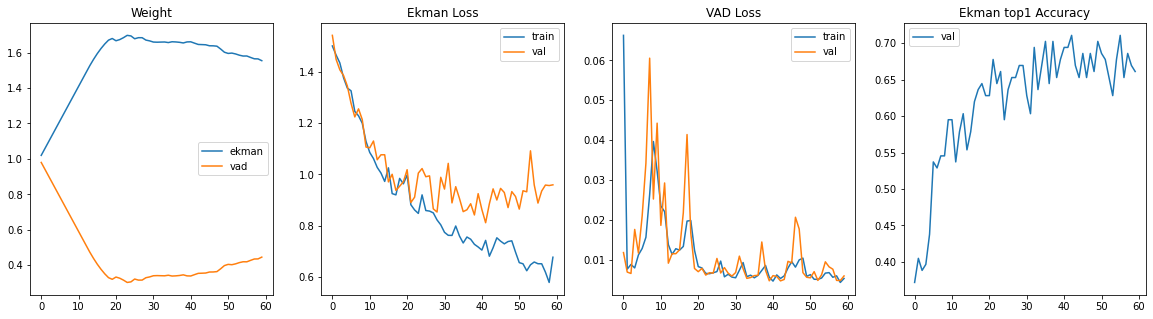

In [46]:
training_manager_multi.plot_history()

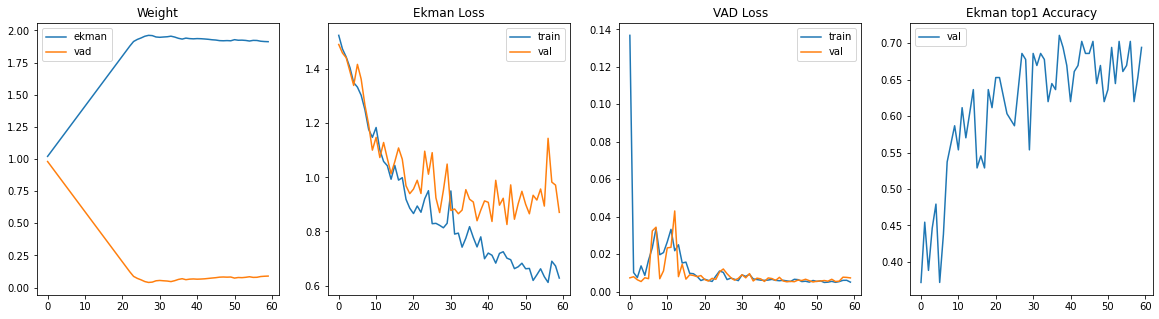

In [ ]:
# GradNorm combined
training_manager_multi.plot_history()

### Grad Norm, without overwriting optimizer (didn't work)

### Debugging Grad Norm

In [173]:
net_debug = MultiheadNetwork(bert)
net_debug.to(DEVICE)
training_manager_debug = TrainingManager(net_debug, dataloader, with_gradNorm=True, alpha=1.0)

In [ ]:
training_manager_debug.train(epochs=60, train_label='combined', val_label='combined')

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

recomputing L0...


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 1: train_avg_loss = 1.534
Epoch 1: ekman_loss = 1.510, vad_loss = 0.150
Epoch 1: val_avg_loss = 0.777
Epoch 1: ekman_loss = 1.528, vad_loss = 0.019
Epoch 1: val_ekman_accuracy = 0.322
Epoch 1: avg. loss_weights = [1.0160945653915405, 0.9839053750038147]
Epoch 1: avg. loss_ratios (inv. train rate) = [0.9465569853782654, 0.1554853618144989]
tensor([1.5954, 0.9658], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2: train_avg_loss = 1.475
Epoch 2: ekman_loss = 1.475, vad_loss = 0.008
Epoch 2: val_avg_loss = 0.744
Epoch 2: ekman_loss = 1.471, vad_loss = 0.010
Epoch 2: val_ekman_accuracy = 0.405
Epoch 2: avg. loss_weights = [1.033130168914795, 0.9668698310852051]
Epoch 2: avg. loss_ratios (inv. train rate) = [0.9881593585014343, 0.4445325434207916]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3: train_avg_loss = 1.422
Epoch 3: ekman_loss = 1.422, vad_loss = 0.008
Epoch 3: val_avg_loss = 0.718
Epoch 3: ekman_loss = 1.419, vad_loss = 0.012
Epoch 3: val_ekman_accuracy = 0.405
Epoch 3: avg. loss_weights = [1.0321542024612427, 0.9678457975387573]
Epoch 3: avg. loss_ratios (inv. train rate) = [0.9529488682746887, 0.42909157276153564]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4: train_avg_loss = 1.397
Epoch 4: ekman_loss = 1.397, vad_loss = 0.011
Epoch 4: val_avg_loss = 0.699
Epoch 4: ekman_loss = 1.376, vad_loss = 0.017
Epoch 4: val_ekman_accuracy = 0.388
Epoch 4: avg. loss_weights = [1.0270695686340332, 0.9729303121566772]
Epoch 4: avg. loss_ratios (inv. train rate) = [0.9362541437149048, 0.614339292049408]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5: train_avg_loss = 1.352
Epoch 5: ekman_loss = 1.352, vad_loss = 0.012
Epoch 5: val_avg_loss = 0.673
Epoch 5: ekman_loss = 1.330, vad_loss = 0.011
Epoch 5: val_ekman_accuracy = 0.421
Epoch 5: avg. loss_weights = [1.0137803554534912, 0.9862195253372192]
Epoch 5: avg. loss_ratios (inv. train rate) = [0.9059110879898071, 0.6658019423484802]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6: train_avg_loss = 1.349
Epoch 6: ekman_loss = 1.349, vad_loss = 0.013
Epoch 6: val_avg_loss = 0.653
Epoch 6: ekman_loss = 1.292, vad_loss = 0.008
Epoch 6: val_ekman_accuracy = 0.463
Epoch 6: avg. loss_weights = [0.9976852536201477, 1.002314805984497]
Epoch 6: avg. loss_ratios (inv. train rate) = [0.9037684202194214, 0.703344464302063]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7: train_avg_loss = 1.273
Epoch 7: ekman_loss = 1.273, vad_loss = 0.011
Epoch 7: val_avg_loss = 0.629
Epoch 7: ekman_loss = 1.246, vad_loss = 0.008
Epoch 7: val_ekman_accuracy = 0.496
Epoch 7: avg. loss_weights = [0.9701112508773804, 1.0298887491226196]
Epoch 7: avg. loss_ratios (inv. train rate) = [0.8530073165893555, 0.5858942866325378]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8: train_avg_loss = 1.224
Epoch 8: ekman_loss = 1.224, vad_loss = 0.013
Epoch 8: val_avg_loss = 0.605
Epoch 8: ekman_loss = 1.194, vad_loss = 0.011
Epoch 8: val_ekman_accuracy = 0.545
Epoch 8: avg. loss_weights = [0.9456959366798401, 1.0543041229248047]
Epoch 8: avg. loss_ratios (inv. train rate) = [0.8204615116119385, 0.6810341477394104]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9: train_avg_loss = 1.186
Epoch 9: ekman_loss = 1.186, vad_loss = 0.008
Epoch 9: val_avg_loss = 0.602
Epoch 9: ekman_loss = 1.182, vad_loss = 0.018
Epoch 9: val_ekman_accuracy = 0.570
Epoch 9: avg. loss_weights = [0.9241723418235779, 1.075827717781067]
Epoch 9: avg. loss_ratios (inv. train rate) = [0.7950183749198914, 0.45735666155815125]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10: train_avg_loss = 1.216
Epoch 10: ekman_loss = 1.216, vad_loss = 0.013
Epoch 10: val_avg_loss = 0.599
Epoch 10: ekman_loss = 1.175, vad_loss = 0.017
Epoch 10: val_ekman_accuracy = 0.570
Epoch 10: avg. loss_weights = [0.8982475399971008, 1.1017522811889648]
Epoch 10: avg. loss_ratios (inv. train rate) = [0.8150742650032043, 0.7300556302070618]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11: train_avg_loss = 1.141
Epoch 11: ekman_loss = 1.141, vad_loss = 0.009
Epoch 11: val_avg_loss = 0.577
Epoch 11: ekman_loss = 1.139, vad_loss = 0.010
Epoch 11: val_ekman_accuracy = 0.612
Epoch 11: avg. loss_weights = [0.8608500957489014, 1.1391499042510986]
Epoch 11: avg. loss_ratios (inv. train rate) = [0.7644432783126831, 0.5043543577194214]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12: train_avg_loss = 1.095
Epoch 12: ekman_loss = 1.095, vad_loss = 0.007
Epoch 12: val_avg_loss = 0.543
Epoch 12: ekman_loss = 1.074, vad_loss = 0.007
Epoch 12: val_ekman_accuracy = 0.587
Epoch 12: avg. loss_weights = [0.8291959762573242, 1.1708039045333862]
Epoch 12: avg. loss_ratios (inv. train rate) = [0.733635425567627, 0.35449740290641785]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13: train_avg_loss = 1.068
Epoch 13: ekman_loss = 1.068, vad_loss = 0.007
Epoch 13: val_avg_loss = 0.542
Epoch 13: ekman_loss = 1.071, vad_loss = 0.008
Epoch 13: val_ekman_accuracy = 0.612
Epoch 13: avg. loss_weights = [0.8021377921104431, 1.1978620290756226]
Epoch 13: avg. loss_ratios (inv. train rate) = [0.715379536151886, 0.3679276704788208]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14: train_avg_loss = 1.065
Epoch 14: ekman_loss = 1.065, vad_loss = 0.006
Epoch 14: val_avg_loss = 0.587
Epoch 14: ekman_loss = 1.158, vad_loss = 0.012
Epoch 14: val_ekman_accuracy = 0.496
Epoch 14: avg. loss_weights = [0.7782277464866638, 1.22177255153656]
Epoch 14: avg. loss_ratios (inv. train rate) = [0.7135624885559082, 0.34124240279197693]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15: train_avg_loss = 1.081
Epoch 15: ekman_loss = 1.081, vad_loss = 0.011
Epoch 15: val_avg_loss = 0.543
Epoch 15: ekman_loss = 1.074, vad_loss = 0.008
Epoch 15: val_ekman_accuracy = 0.628
Epoch 15: avg. loss_weights = [0.7438489198684692, 1.2561510801315308]
Epoch 15: avg. loss_ratios (inv. train rate) = [0.7244771122932434, 0.5963125228881836]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16: train_avg_loss = 1.015
Epoch 16: ekman_loss = 1.015, vad_loss = 0.007
Epoch 16: val_avg_loss = 0.622
Epoch 16: ekman_loss = 1.221, vad_loss = 0.018
Epoch 16: val_ekman_accuracy = 0.529
Epoch 16: avg. loss_weights = [0.7091198563575745, 1.2908802032470703]
Epoch 16: avg. loss_ratios (inv. train rate) = [0.6799348592758179, 0.3622366189956665]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17: train_avg_loss = 1.014
Epoch 17: ekman_loss = 1.014, vad_loss = 0.011
Epoch 17: val_avg_loss = 0.499
Epoch 17: ekman_loss = 0.987, vad_loss = 0.008
Epoch 17: val_ekman_accuracy = 0.620
Epoch 17: avg. loss_weights = [0.6725791096687317, 1.3274211883544922]
Epoch 17: avg. loss_ratios (inv. train rate) = [0.6792489290237427, 0.5804865956306458]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18: train_avg_loss = 0.987
Epoch 18: ekman_loss = 0.987, vad_loss = 0.006
Epoch 18: val_avg_loss = 0.521
Epoch 18: ekman_loss = 1.025, vad_loss = 0.013
Epoch 18: val_ekman_accuracy = 0.636
Epoch 18: avg. loss_weights = [0.6435508131980896, 1.3564491271972656]
Epoch 18: avg. loss_ratios (inv. train rate) = [0.6612498164176941, 0.34419137239456177]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19: train_avg_loss = 0.981
Epoch 19: ekman_loss = 0.981, vad_loss = 0.005
Epoch 19: val_avg_loss = 0.504
Epoch 19: ekman_loss = 0.999, vad_loss = 0.005
Epoch 19: val_ekman_accuracy = 0.645
Epoch 19: avg. loss_weights = [0.6126828789710999, 1.3873172998428345]
Epoch 19: avg. loss_ratios (inv. train rate) = [0.6573237180709839, 0.2700572907924652]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20: train_avg_loss = 0.945
Epoch 20: ekman_loss = 0.945, vad_loss = 0.005
Epoch 20: val_avg_loss = 0.487
Epoch 20: ekman_loss = 0.964, vad_loss = 0.005
Epoch 20: val_ekman_accuracy = 0.620
Epoch 20: avg. loss_weights = [0.5819320678710938, 1.4180679321289062]
Epoch 20: avg. loss_ratios (inv. train rate) = [0.6330105066299438, 0.2544497847557068]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21: train_avg_loss = 0.936
Epoch 21: ekman_loss = 0.936, vad_loss = 0.005
Epoch 21: val_avg_loss = 0.486
Epoch 21: ekman_loss = 0.961, vad_loss = 0.008
Epoch 21: val_ekman_accuracy = 0.661
Epoch 21: avg. loss_weights = [0.557167112827301, 1.4428327083587646]
Epoch 21: avg. loss_ratios (inv. train rate) = [0.6273663640022278, 0.25569626688957214]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22: train_avg_loss = 0.949
Epoch 22: ekman_loss = 0.949, vad_loss = 0.005
Epoch 22: val_avg_loss = 0.493
Epoch 22: ekman_loss = 0.973, vad_loss = 0.009
Epoch 22: val_ekman_accuracy = 0.587
Epoch 22: avg. loss_weights = [0.5267744064331055, 1.473225474357605]
Epoch 22: avg. loss_ratios (inv. train rate) = [0.6361947059631348, 0.27054688334465027]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23: train_avg_loss = 0.906
Epoch 23: ekman_loss = 0.906, vad_loss = 0.004
Epoch 23: val_avg_loss = 0.470
Epoch 23: ekman_loss = 0.929, vad_loss = 0.006
Epoch 23: val_ekman_accuracy = 0.645
Epoch 23: avg. loss_weights = [0.49559393525123596, 1.5044059753417969]
Epoch 23: avg. loss_ratios (inv. train rate) = [0.6070279479026794, 0.2411639392375946]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24: train_avg_loss = 0.890
Epoch 24: ekman_loss = 0.890, vad_loss = 0.005
Epoch 24: val_avg_loss = 0.470
Epoch 24: ekman_loss = 0.932, vad_loss = 0.004
Epoch 24: val_ekman_accuracy = 0.661
Epoch 24: avg. loss_weights = [0.46702146530151367, 1.5329785346984863]
Epoch 24: avg. loss_ratios (inv. train rate) = [0.5962361693382263, 0.2850343883037567]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25: train_avg_loss = 0.882
Epoch 25: ekman_loss = 0.882, vad_loss = 0.004
Epoch 25: val_avg_loss = 0.471
Epoch 25: ekman_loss = 0.932, vad_loss = 0.005
Epoch 25: val_ekman_accuracy = 0.661
Epoch 25: avg. loss_weights = [0.43795111775398254, 1.562049150466919]
Epoch 25: avg. loss_ratios (inv. train rate) = [0.5911189913749695, 0.21920627355575562]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26: train_avg_loss = 0.860
Epoch 26: ekman_loss = 0.860, vad_loss = 0.004
Epoch 26: val_avg_loss = 0.465
Epoch 26: ekman_loss = 0.923, vad_loss = 0.004
Epoch 26: val_ekman_accuracy = 0.661
Epoch 26: avg. loss_weights = [0.4056064784526825, 1.5943933725357056]
Epoch 26: avg. loss_ratios (inv. train rate) = [0.576603889465332, 0.22436435520648956]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27: train_avg_loss = 0.863
Epoch 27: ekman_loss = 0.863, vad_loss = 0.004
Epoch 27: val_avg_loss = 0.462
Epoch 27: ekman_loss = 0.916, vad_loss = 0.004
Epoch 27: val_ekman_accuracy = 0.678
Epoch 27: avg. loss_weights = [0.3803444504737854, 1.6196556091308594]
Epoch 27: avg. loss_ratios (inv. train rate) = [0.5781115889549255, 0.2146921455860138]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28: train_avg_loss = 0.862
Epoch 28: ekman_loss = 0.862, vad_loss = 0.004
Epoch 28: val_avg_loss = 0.471
Epoch 28: ekman_loss = 0.935, vad_loss = 0.004
Epoch 28: val_ekman_accuracy = 0.636
Epoch 28: avg. loss_weights = [0.3498288094997406, 1.6501712799072266]
Epoch 28: avg. loss_ratios (inv. train rate) = [0.577781617641449, 0.22631129622459412]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29: train_avg_loss = 0.841
Epoch 29: ekman_loss = 0.841, vad_loss = 0.004
Epoch 29: val_avg_loss = 0.453
Epoch 29: ekman_loss = 0.897, vad_loss = 0.004
Epoch 29: val_ekman_accuracy = 0.678
Epoch 29: avg. loss_weights = [0.32955414056777954, 1.6704455614089966]
Epoch 29: avg. loss_ratios (inv. train rate) = [0.5638341307640076, 0.22618533670902252]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30: train_avg_loss = 0.876
Epoch 30: ekman_loss = 0.876, vad_loss = 0.004
Epoch 30: val_avg_loss = 0.535
Epoch 30: ekman_loss = 1.062, vad_loss = 0.005
Epoch 30: val_ekman_accuracy = 0.587
Epoch 30: avg. loss_weights = [0.31572872400283813, 1.6842714548110962]
Epoch 30: avg. loss_ratios (inv. train rate) = [0.5868275761604309, 0.21130184829235077]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31: train_avg_loss = 0.889
Epoch 31: ekman_loss = 0.889, vad_loss = 0.004
Epoch 31: val_avg_loss = 0.574
Epoch 31: ekman_loss = 1.139, vad_loss = 0.004
Epoch 31: val_ekman_accuracy = 0.529
Epoch 31: avg. loss_weights = [0.28841543197631836, 1.7115846872329712]
Epoch 31: avg. loss_ratios (inv. train rate) = [0.5954040884971619, 0.20960254967212677]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32: train_avg_loss = 0.891
Epoch 32: ekman_loss = 0.891, vad_loss = 0.004
Epoch 32: val_avg_loss = 0.461
Epoch 32: ekman_loss = 0.914, vad_loss = 0.004
Epoch 32: val_ekman_accuracy = 0.661
Epoch 32: avg. loss_weights = [0.2530362904071808, 1.7469640970230103]
Epoch 32: avg. loss_ratios (inv. train rate) = [0.5969318151473999, 0.2135508805513382]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33: train_avg_loss = 0.852
Epoch 33: ekman_loss = 0.852, vad_loss = 0.004
Epoch 33: val_avg_loss = 0.444
Epoch 33: ekman_loss = 0.881, vad_loss = 0.004
Epoch 33: val_ekman_accuracy = 0.678
Epoch 33: avg. loss_weights = [0.2365715354681015, 1.7634283304214478]
Epoch 33: avg. loss_ratios (inv. train rate) = [0.5710703730583191, 0.21311238408088684]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34: train_avg_loss = 0.794
Epoch 34: ekman_loss = 0.794, vad_loss = 0.004
Epoch 34: val_avg_loss = 0.438
Epoch 34: ekman_loss = 0.868, vad_loss = 0.005
Epoch 34: val_ekman_accuracy = 0.694
Epoch 34: avg. loss_weights = [0.23378634452819824, 1.7662140130996704]
Epoch 34: avg. loss_ratios (inv. train rate) = [0.5323624014854431, 0.19534651935100555]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35: train_avg_loss = 0.808
Epoch 35: ekman_loss = 0.808, vad_loss = 0.004
Epoch 35: val_avg_loss = 0.442
Epoch 35: ekman_loss = 0.876, vad_loss = 0.004
Epoch 35: val_ekman_accuracy = 0.653
Epoch 35: avg. loss_weights = [0.2347816824913025, 1.7652181386947632]
Epoch 35: avg. loss_ratios (inv. train rate) = [0.541620135307312, 0.21912667155265808]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36: train_avg_loss = 0.793
Epoch 36: ekman_loss = 0.793, vad_loss = 0.003
Epoch 36: val_avg_loss = 0.433
Epoch 36: ekman_loss = 0.859, vad_loss = 0.004
Epoch 36: val_ekman_accuracy = 0.686
Epoch 36: avg. loss_weights = [0.23367713391780853, 1.7663229703903198]
Epoch 36: avg. loss_ratios (inv. train rate) = [0.531647264957428, 0.17914269864559174]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37: train_avg_loss = 0.791
Epoch 37: ekman_loss = 0.791, vad_loss = 0.003
Epoch 37: val_avg_loss = 0.432
Epoch 37: ekman_loss = 0.856, vad_loss = 0.005
Epoch 37: val_ekman_accuracy = 0.669
Epoch 37: avg. loss_weights = [0.23027274012565613, 1.7697274684906006]
Epoch 37: avg. loss_ratios (inv. train rate) = [0.5301340818405151, 0.17974357306957245]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38: train_avg_loss = 0.773
Epoch 38: ekman_loss = 0.773, vad_loss = 0.003
Epoch 38: val_avg_loss = 0.451
Epoch 38: ekman_loss = 0.894, vad_loss = 0.004
Epoch 38: val_ekman_accuracy = 0.694
Epoch 38: avg. loss_weights = [0.22402286529541016, 1.7759774923324585]
Epoch 38: avg. loss_ratios (inv. train rate) = [0.5180591940879822, 0.18050023913383484]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39: train_avg_loss = 0.793
Epoch 39: ekman_loss = 0.793, vad_loss = 0.003
Epoch 39: val_avg_loss = 0.447
Epoch 39: ekman_loss = 0.887, vad_loss = 0.004
Epoch 39: val_ekman_accuracy = 0.628
Epoch 39: avg. loss_weights = [0.21616272628307343, 1.7838373184204102]
Epoch 39: avg. loss_ratios (inv. train rate) = [0.531212329864502, 0.18426361680030823]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40: train_avg_loss = 0.780
Epoch 40: ekman_loss = 0.780, vad_loss = 0.003
Epoch 40: val_avg_loss = 0.428
Epoch 40: ekman_loss = 0.848, vad_loss = 0.004
Epoch 40: val_ekman_accuracy = 0.661
Epoch 40: avg. loss_weights = [0.20699429512023926, 1.7930059432983398]
Epoch 40: avg. loss_ratios (inv. train rate) = [0.5229007005691528, 0.17374183237552643]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41: train_avg_loss = 0.766
Epoch 41: ekman_loss = 0.766, vad_loss = 0.003
Epoch 41: val_avg_loss = 0.452
Epoch 41: ekman_loss = 0.896, vad_loss = 0.004
Epoch 41: val_ekman_accuracy = 0.686
Epoch 41: avg. loss_weights = [0.20521950721740723, 1.7947804927825928]
Epoch 41: avg. loss_ratios (inv. train rate) = [0.5133419036865234, 0.17888613045215607]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42: train_avg_loss = 0.758
Epoch 42: ekman_loss = 0.758, vad_loss = 0.003
Epoch 42: val_avg_loss = 0.438
Epoch 42: ekman_loss = 0.868, vad_loss = 0.004
Epoch 42: val_ekman_accuracy = 0.686
Epoch 42: avg. loss_weights = [0.20133545994758606, 1.7986645698547363]
Epoch 42: avg. loss_ratios (inv. train rate) = [0.5078761577606201, 0.1778949648141861]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43: train_avg_loss = 0.756
Epoch 43: ekman_loss = 0.756, vad_loss = 0.003
Epoch 43: val_avg_loss = 0.443
Epoch 43: ekman_loss = 0.878, vad_loss = 0.004
Epoch 43: val_ekman_accuracy = 0.678
Epoch 43: avg. loss_weights = [0.20212480425834656, 1.7978750467300415]
Epoch 43: avg. loss_ratios (inv. train rate) = [0.5068472623825073, 0.18321312963962555]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44: train_avg_loss = 0.775
Epoch 44: ekman_loss = 0.775, vad_loss = 0.004
Epoch 44: val_avg_loss = 0.485
Epoch 44: ekman_loss = 0.962, vad_loss = 0.004
Epoch 44: val_ekman_accuracy = 0.661
Epoch 44: avg. loss_weights = [0.20728641748428345, 1.7927134037017822]
Epoch 44: avg. loss_ratios (inv. train rate) = [0.51948481798172, 0.19100120663642883]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45: train_avg_loss = 0.755
Epoch 45: ekman_loss = 0.755, vad_loss = 0.003
Epoch 45: val_avg_loss = 0.428
Epoch 45: ekman_loss = 0.849, vad_loss = 0.004
Epoch 45: val_ekman_accuracy = 0.669
Epoch 45: avg. loss_weights = [0.20658986270427704, 1.793410062789917]
Epoch 45: avg. loss_ratios (inv. train rate) = [0.5060874223709106, 0.17062535881996155]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46: train_avg_loss = 0.772
Epoch 46: ekman_loss = 0.772, vad_loss = 0.003
Epoch 46: val_avg_loss = 0.430
Epoch 46: ekman_loss = 0.853, vad_loss = 0.004
Epoch 46: val_ekman_accuracy = 0.702
Epoch 46: avg. loss_weights = [0.19593162834644318, 1.8040685653686523]
Epoch 46: avg. loss_ratios (inv. train rate) = [0.5173068642616272, 0.17830079793930054]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47: train_avg_loss = 0.763
Epoch 47: ekman_loss = 0.763, vad_loss = 0.004
Epoch 47: val_avg_loss = 0.499
Epoch 47: ekman_loss = 0.991, vad_loss = 0.004
Epoch 47: val_ekman_accuracy = 0.645
Epoch 47: avg. loss_weights = [0.17913849651813507, 1.8208612203598022]
Epoch 47: avg. loss_ratios (inv. train rate) = [0.5113399028778076, 0.19168877601623535]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48: train_avg_loss = 0.743
Epoch 48: ekman_loss = 0.743, vad_loss = 0.004
Epoch 48: val_avg_loss = 0.440
Epoch 48: ekman_loss = 0.871, vad_loss = 0.005
Epoch 48: val_ekman_accuracy = 0.669
Epoch 48: avg. loss_weights = [0.17920640110969543, 1.8207939863204956]
Epoch 48: avg. loss_ratios (inv. train rate) = [0.49763166904449463, 0.19270867109298706]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49: train_avg_loss = 0.737
Epoch 49: ekman_loss = 0.737, vad_loss = 0.003
Epoch 49: val_avg_loss = 0.433
Epoch 49: ekman_loss = 0.858, vad_loss = 0.005
Epoch 49: val_ekman_accuracy = 0.645
Epoch 49: avg. loss_weights = [0.18510057032108307, 1.8148993253707886]
Epoch 49: avg. loss_ratios (inv. train rate) = [0.49409905076026917, 0.16475149989128113]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50: train_avg_loss = 0.721
Epoch 50: ekman_loss = 0.721, vad_loss = 0.004
Epoch 50: val_avg_loss = 0.433
Epoch 50: ekman_loss = 0.857, vad_loss = 0.005
Epoch 50: val_ekman_accuracy = 0.694
Epoch 50: avg. loss_weights = [0.18848495185375214, 1.8115154504776]
Epoch 50: avg. loss_ratios (inv. train rate) = [0.48345205187797546, 0.19326257705688477]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51: train_avg_loss = 0.725
Epoch 51: ekman_loss = 0.725, vad_loss = 0.003
Epoch 51: val_avg_loss = 0.431
Epoch 51: ekman_loss = 0.853, vad_loss = 0.006
Epoch 51: val_ekman_accuracy = 0.678
Epoch 51: avg. loss_weights = [0.19371642172336578, 1.8062835931777954]
Epoch 51: avg. loss_ratios (inv. train rate) = [0.48570340871810913, 0.17201350629329681]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52: train_avg_loss = 0.737
Epoch 52: ekman_loss = 0.737, vad_loss = 0.004
Epoch 52: val_avg_loss = 0.418
Epoch 52: ekman_loss = 0.827, vad_loss = 0.005
Epoch 52: val_ekman_accuracy = 0.686
Epoch 52: avg. loss_weights = [0.18789750337600708, 1.8121024370193481]
Epoch 52: avg. loss_ratios (inv. train rate) = [0.49365392327308655, 0.19116832315921783]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53: train_avg_loss = 0.718
Epoch 53: ekman_loss = 0.718, vad_loss = 0.003
Epoch 53: val_avg_loss = 0.424
Epoch 53: ekman_loss = 0.840, vad_loss = 0.005
Epoch 53: val_ekman_accuracy = 0.694
Epoch 53: avg. loss_weights = [0.18546804785728455, 1.814531922340393]
Epoch 53: avg. loss_ratios (inv. train rate) = [0.4810808598995209, 0.18420226871967316]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54: train_avg_loss = 0.718
Epoch 54: ekman_loss = 0.718, vad_loss = 0.003
Epoch 54: val_avg_loss = 0.430
Epoch 54: ekman_loss = 0.853, vad_loss = 0.004
Epoch 54: val_ekman_accuracy = 0.702
Epoch 54: avg. loss_weights = [0.1754717230796814, 1.8245285749435425]
Epoch 54: avg. loss_ratios (inv. train rate) = [0.48133131861686707, 0.17443446815013885]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55: train_avg_loss = 0.700
Epoch 55: ekman_loss = 0.700, vad_loss = 0.003
Epoch 55: val_avg_loss = 0.429
Epoch 55: ekman_loss = 0.850, vad_loss = 0.004
Epoch 55: val_ekman_accuracy = 0.669
Epoch 55: avg. loss_weights = [0.17486974596977234, 1.8251303434371948]
Epoch 55: avg. loss_ratios (inv. train rate) = [0.46893930435180664, 0.16317975521087646]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56: train_avg_loss = 0.707
Epoch 56: ekman_loss = 0.707, vad_loss = 0.003
Epoch 56: val_avg_loss = 0.426
Epoch 56: ekman_loss = 0.844, vad_loss = 0.004
Epoch 56: val_ekman_accuracy = 0.636
Epoch 56: avg. loss_weights = [0.1735464185476303, 1.8264538049697876]
Epoch 56: avg. loss_ratios (inv. train rate) = [0.4736151099205017, 0.15953613817691803]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57: train_avg_loss = 0.715
Epoch 57: ekman_loss = 0.715, vad_loss = 0.003
Epoch 57: val_avg_loss = 0.431
Epoch 57: ekman_loss = 0.854, vad_loss = 0.004
Epoch 57: val_ekman_accuracy = 0.694
Epoch 57: avg. loss_weights = [0.1634369194507599, 1.8365631103515625]
Epoch 57: avg. loss_ratios (inv. train rate) = [0.4793226718902588, 0.17370381951332092]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58: train_avg_loss = 0.680
Epoch 58: ekman_loss = 0.680, vad_loss = 0.003
Epoch 58: val_avg_loss = 0.482
Epoch 58: ekman_loss = 0.956, vad_loss = 0.004
Epoch 58: val_ekman_accuracy = 0.661
Epoch 58: avg. loss_weights = [0.16038142144680023, 1.8396185636520386]
Epoch 58: avg. loss_ratios (inv. train rate) = [0.45584219694137573, 0.1631736308336258]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59: train_avg_loss = 0.722
Epoch 59: ekman_loss = 0.722, vad_loss = 0.003
Epoch 59: val_avg_loss = 0.432
Epoch 59: ekman_loss = 0.856, vad_loss = 0.004
Epoch 59: val_ekman_accuracy = 0.686
Epoch 59: avg. loss_weights = [0.16006234288215637, 1.839937686920166]
Epoch 59: avg. loss_ratios (inv. train rate) = [0.4835825562477112, 0.17450906336307526]
tensor([1.4923, 0.0184], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

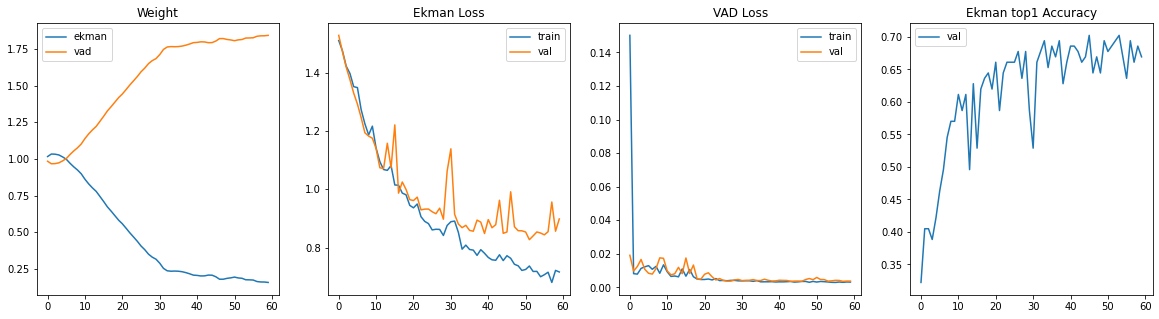

In [175]:
training_manager_debug.plot_history()

### Grad Norm, with updating L0 to be first epoch loss value

In [115]:
net_sameOpt = MultiheadNetwork(bert)
net_sameOpt.to(DEVICE)
training_manager_sameOpt = TrainingManager(net_sameOpt, dataloader, with_gradNorm=True, alpha=1.0)

In [116]:
training_manager_sameOpt.train(epochs=60, train_label='combined', val_label='combined')

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

recomputing L0...


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 1: train_avg_loss = 1.575
Epoch 1: ekman_loss = 1.519, vad_loss = 0.324
Epoch 1: val_avg_loss = 0.744
Epoch 1: ekman_loss = 1.470, vad_loss = 0.012
Epoch 1: val_ekman_accuracy = 0.380
Epoch 1: avg. loss_weights = [1.0190002918243408, 0.980999767780304]
Epoch 1: avg. loss_ratios (inv. train rate) = [0.9365856647491455, 0.3463645875453949]
tensor([1.6215, 0.9351], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

tensor([1.3433, 0.0101], device='cuda:0', grad_fn=<CopySlices>)
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2: train_avg_loss = 1.465
Epoch 2: ekman_loss = 1.465, vad_loss = 0.010
Epoch 2: val_avg_loss = 0.746
Epoch 2: ekman_loss = 1.479, vad_loss = 0.006
Epoch 2: val_ekman_accuracy = 0.430
Epoch 2: avg. loss_weights = [1.026103138923645, 0.9738969206809998]
Epoch 2: avg. loss_ratios (inv. train rate) = [0.9958084225654602, 0.7375267744064331]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3: train_avg_loss = 1.434
Epoch 3: ekman_loss = 1.434, vad_loss = 0.006
Epoch 3: val_avg_loss = 0.719
Epoch 3: ekman_loss = 1.426, vad_loss = 0.005
Epoch 3: val_ekman_accuracy = 0.463
Epoch 3: avg. loss_weights = [1.0000261068344116, 0.9999737739562988]
Epoch 3: avg. loss_ratios (inv. train rate) = [0.9746363759040833, 0.4742065966129303]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4: train_avg_loss = 1.419
Epoch 4: ekman_loss = 1.419, vad_loss = 0.006
Epoch 4: val_avg_loss = 0.705
Epoch 4: ekman_loss = 1.399, vad_loss = 0.006
Epoch 4: val_ekman_accuracy = 0.455
Epoch 4: avg. loss_weights = [0.972615659236908, 1.0273845195770264]
Epoch 4: avg. loss_ratios (inv. train rate) = [0.9647485613822937, 0.47578397393226624]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5: train_avg_loss = 1.386
Epoch 5: ekman_loss = 1.386, vad_loss = 0.006
Epoch 5: val_avg_loss = 0.700
Epoch 5: ekman_loss = 1.388, vad_loss = 0.007
Epoch 5: val_ekman_accuracy = 0.397
Epoch 5: avg. loss_weights = [0.9535638093948364, 1.046436071395874]
Epoch 5: avg. loss_ratios (inv. train rate) = [0.9419733881950378, 0.4550284743309021]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6: train_avg_loss = 1.332
Epoch 6: ekman_loss = 1.332, vad_loss = 0.006
Epoch 6: val_avg_loss = 0.705
Epoch 6: ekman_loss = 1.396, vad_loss = 0.007
Epoch 6: val_ekman_accuracy = 0.397
Epoch 6: avg. loss_weights = [0.9394866824150085, 1.0605133771896362]
Epoch 6: avg. loss_ratios (inv. train rate) = [0.9056168794631958, 0.42551252245903015]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7: train_avg_loss = 1.317
Epoch 7: ekman_loss = 1.317, vad_loss = 0.007
Epoch 7: val_avg_loss = 0.670
Epoch 7: ekman_loss = 1.325, vad_loss = 0.009
Epoch 7: val_ekman_accuracy = 0.537
Epoch 7: avg. loss_weights = [0.9097679257392883, 1.090232014656067]
Epoch 7: avg. loss_ratios (inv. train rate) = [0.8952317833900452, 0.5250211358070374]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8: train_avg_loss = 1.260
Epoch 8: ekman_loss = 1.260, vad_loss = 0.005
Epoch 8: val_avg_loss = 0.632
Epoch 8: ekman_loss = 1.253, vad_loss = 0.005
Epoch 8: val_ekman_accuracy = 0.471
Epoch 8: avg. loss_weights = [0.8768186569213867, 1.1231813430786133]
Epoch 8: avg. loss_ratios (inv. train rate) = [0.8562292456626892, 0.41170835494995117]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9: train_avg_loss = 1.219
Epoch 9: ekman_loss = 1.219, vad_loss = 0.005
Epoch 9: val_avg_loss = 0.638
Epoch 9: ekman_loss = 1.265, vad_loss = 0.005
Epoch 9: val_ekman_accuracy = 0.479
Epoch 9: avg. loss_weights = [0.8426899313926697, 1.1573102474212646]
Epoch 9: avg. loss_ratios (inv. train rate) = [0.8284100294113159, 0.3988020122051239]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10: train_avg_loss = 1.175
Epoch 10: ekman_loss = 1.175, vad_loss = 0.005
Epoch 10: val_avg_loss = 0.622
Epoch 10: ekman_loss = 1.232, vad_loss = 0.007
Epoch 10: val_ekman_accuracy = 0.562
Epoch 10: avg. loss_weights = [0.8076380491256714, 1.1923620700836182]
Epoch 10: avg. loss_ratios (inv. train rate) = [0.7984002232551575, 0.4120202660560608]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11: train_avg_loss = 1.127
Epoch 11: ekman_loss = 1.127, vad_loss = 0.005
Epoch 11: val_avg_loss = 0.602
Epoch 11: ekman_loss = 1.192, vad_loss = 0.008
Epoch 11: val_ekman_accuracy = 0.579
Epoch 11: avg. loss_weights = [0.7717656493186951, 1.2282345294952393]
Epoch 11: avg. loss_ratios (inv. train rate) = [0.7660029530525208, 0.3641415238380432]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12: train_avg_loss = 1.113
Epoch 12: ekman_loss = 1.113, vad_loss = 0.006
Epoch 12: val_avg_loss = 0.560
Epoch 12: ekman_loss = 1.108, vad_loss = 0.006
Epoch 12: val_ekman_accuracy = 0.554
Epoch 12: avg. loss_weights = [0.7411754727363586, 1.2588245868682861]
Epoch 12: avg. loss_ratios (inv. train rate) = [0.7566992044448853, 0.4272541105747223]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13: train_avg_loss = 1.076
Epoch 13: ekman_loss = 1.076, vad_loss = 0.005
Epoch 13: val_avg_loss = 0.541
Epoch 13: ekman_loss = 1.071, vad_loss = 0.006
Epoch 13: val_ekman_accuracy = 0.645
Epoch 13: avg. loss_weights = [0.7160727381706238, 1.2839272022247314]
Epoch 13: avg. loss_ratios (inv. train rate) = [0.7315577268600464, 0.3851119875907898]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14: train_avg_loss = 1.066
Epoch 14: ekman_loss = 1.066, vad_loss = 0.006
Epoch 14: val_avg_loss = 0.545
Epoch 14: ekman_loss = 1.080, vad_loss = 0.005
Epoch 14: val_ekman_accuracy = 0.612
Epoch 14: avg. loss_weights = [0.687687873840332, 1.3123122453689575]
Epoch 14: avg. loss_ratios (inv. train rate) = [0.7243239879608154, 0.4436412751674652]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15: train_avg_loss = 1.032
Epoch 15: ekman_loss = 1.032, vad_loss = 0.005
Epoch 15: val_avg_loss = 0.583
Epoch 15: ekman_loss = 1.153, vad_loss = 0.008
Epoch 15: val_ekman_accuracy = 0.554
Epoch 15: avg. loss_weights = [0.6525851488113403, 1.3474150896072388]
Epoch 15: avg. loss_ratios (inv. train rate) = [0.7014079689979553, 0.34882786870002747]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16: train_avg_loss = 1.066
Epoch 16: ekman_loss = 1.066, vad_loss = 0.007
Epoch 16: val_avg_loss = 0.529
Epoch 16: ekman_loss = 1.048, vad_loss = 0.007
Epoch 16: val_ekman_accuracy = 0.620
Epoch 16: avg. loss_weights = [0.6178413033485413, 1.3821585178375244]
Epoch 16: avg. loss_ratios (inv. train rate) = [0.7246568202972412, 0.5134950280189514]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17: train_avg_loss = 1.005
Epoch 17: ekman_loss = 1.005, vad_loss = 0.006
Epoch 17: val_avg_loss = 0.518
Epoch 17: ekman_loss = 1.027, vad_loss = 0.005
Epoch 17: val_ekman_accuracy = 0.595
Epoch 17: avg. loss_weights = [0.5869436264038086, 1.4130563735961914]
Epoch 17: avg. loss_ratios (inv. train rate) = [0.6831738948822021, 0.474243700504303]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18: train_avg_loss = 1.020
Epoch 18: ekman_loss = 1.020, vad_loss = 0.005
Epoch 18: val_avg_loss = 0.526
Epoch 18: ekman_loss = 1.044, vad_loss = 0.005
Epoch 18: val_ekman_accuracy = 0.612
Epoch 18: avg. loss_weights = [0.5526613593101501, 1.4473388195037842]
Epoch 18: avg. loss_ratios (inv. train rate) = [0.6932887434959412, 0.3905523419380188]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19: train_avg_loss = 0.967
Epoch 19: ekman_loss = 0.967, vad_loss = 0.004
Epoch 19: val_avg_loss = 0.559
Epoch 19: ekman_loss = 1.108, vad_loss = 0.005
Epoch 19: val_ekman_accuracy = 0.587
Epoch 19: avg. loss_weights = [0.5190970301628113, 1.480902910232544]
Epoch 19: avg. loss_ratios (inv. train rate) = [0.6573888659477234, 0.3010626435279846]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20: train_avg_loss = 1.000
Epoch 20: ekman_loss = 1.000, vad_loss = 0.004
Epoch 20: val_avg_loss = 0.527
Epoch 20: ekman_loss = 1.045, vad_loss = 0.005
Epoch 20: val_ekman_accuracy = 0.562
Epoch 20: avg. loss_weights = [0.4840456247329712, 1.5159543752670288]
Epoch 20: avg. loss_ratios (inv. train rate) = [0.6797369718551636, 0.3375166654586792]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21: train_avg_loss = 0.949
Epoch 21: ekman_loss = 0.949, vad_loss = 0.005
Epoch 21: val_avg_loss = 0.523
Epoch 21: ekman_loss = 1.037, vad_loss = 0.004
Epoch 21: val_ekman_accuracy = 0.595
Epoch 21: avg. loss_weights = [0.45166105031967163, 1.5483390092849731]
Epoch 21: avg. loss_ratios (inv. train rate) = [0.6454190015792847, 0.4093039631843567]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22: train_avg_loss = 0.915
Epoch 22: ekman_loss = 0.915, vad_loss = 0.004
Epoch 22: val_avg_loss = 0.526
Epoch 22: ekman_loss = 1.043, vad_loss = 0.005
Epoch 22: val_ekman_accuracy = 0.570
Epoch 22: avg. loss_weights = [0.4280969202518463, 1.5719029903411865]
Epoch 22: avg. loss_ratios (inv. train rate) = [0.6221749782562256, 0.28707069158554077]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23: train_avg_loss = 0.893
Epoch 23: ekman_loss = 0.893, vad_loss = 0.004
Epoch 23: val_avg_loss = 0.481
Epoch 23: ekman_loss = 0.953, vad_loss = 0.005
Epoch 23: val_ekman_accuracy = 0.669
Epoch 23: avg. loss_weights = [0.41094306111335754, 1.5890566110610962]
Epoch 23: avg. loss_ratios (inv. train rate) = [0.6069129705429077, 0.30012938380241394]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24: train_avg_loss = 0.919
Epoch 24: ekman_loss = 0.919, vad_loss = 0.004
Epoch 24: val_avg_loss = 0.502
Epoch 24: ekman_loss = 0.995, vad_loss = 0.005
Epoch 24: val_ekman_accuracy = 0.620
Epoch 24: avg. loss_weights = [0.3854302763938904, 1.6145695447921753]
Epoch 24: avg. loss_ratios (inv. train rate) = [0.6244449615478516, 0.29008010029792786]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25: train_avg_loss = 0.881
Epoch 25: ekman_loss = 0.881, vad_loss = 0.004
Epoch 25: val_avg_loss = 0.488
Epoch 25: ekman_loss = 0.967, vad_loss = 0.004
Epoch 25: val_ekman_accuracy = 0.612
Epoch 25: avg. loss_weights = [0.3617638349533081, 1.6382362842559814]
Epoch 25: avg. loss_ratios (inv. train rate) = [0.5987535119056702, 0.2713806927204132]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26: train_avg_loss = 0.883
Epoch 26: ekman_loss = 0.883, vad_loss = 0.004
Epoch 26: val_avg_loss = 0.454
Epoch 26: ekman_loss = 0.900, vad_loss = 0.004
Epoch 26: val_ekman_accuracy = 0.686
Epoch 26: avg. loss_weights = [0.3482511341571808, 1.6517486572265625]
Epoch 26: avg. loss_ratios (inv. train rate) = [0.6002152562141418, 0.28644242882728577]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27: train_avg_loss = 0.882
Epoch 27: ekman_loss = 0.882, vad_loss = 0.004
Epoch 27: val_avg_loss = 0.569
Epoch 27: ekman_loss = 1.127, vad_loss = 0.007
Epoch 27: val_ekman_accuracy = 0.545
Epoch 27: avg. loss_weights = [0.34078967571258545, 1.6592108011245728]
Epoch 27: avg. loss_ratios (inv. train rate) = [0.5995516180992126, 0.31591176986694336]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28: train_avg_loss = 0.874
Epoch 28: ekman_loss = 0.874, vad_loss = 0.004
Epoch 28: val_avg_loss = 0.502
Epoch 28: ekman_loss = 0.995, vad_loss = 0.004
Epoch 28: val_ekman_accuracy = 0.579
Epoch 28: avg. loss_weights = [0.33414873480796814, 1.66585111618042]
Epoch 28: avg. loss_ratios (inv. train rate) = [0.5943796038627625, 0.2792491018772125]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29: train_avg_loss = 0.867
Epoch 29: ekman_loss = 0.867, vad_loss = 0.004
Epoch 29: val_avg_loss = 0.455
Epoch 29: ekman_loss = 0.901, vad_loss = 0.004
Epoch 29: val_ekman_accuracy = 0.653
Epoch 29: avg. loss_weights = [0.32361042499542236, 1.6763896942138672]
Epoch 29: avg. loss_ratios (inv. train rate) = [0.5896173715591431, 0.27245277166366577]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30: train_avg_loss = 0.826
Epoch 30: ekman_loss = 0.826, vad_loss = 0.003
Epoch 30: val_avg_loss = 0.452
Epoch 30: ekman_loss = 0.896, vad_loss = 0.004
Epoch 30: val_ekman_accuracy = 0.694
Epoch 30: avg. loss_weights = [0.3052772879600525, 1.6947228908538818]
Epoch 30: avg. loss_ratios (inv. train rate) = [0.5616936087608337, 0.2506771683692932]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31: train_avg_loss = 0.827
Epoch 31: ekman_loss = 0.827, vad_loss = 0.003
Epoch 31: val_avg_loss = 0.452
Epoch 31: ekman_loss = 0.895, vad_loss = 0.004
Epoch 31: val_ekman_accuracy = 0.686
Epoch 31: avg. loss_weights = [0.3005850315093994, 1.6994152069091797]
Epoch 31: avg. loss_ratios (inv. train rate) = [0.5623396039009094, 0.2440623939037323]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32: train_avg_loss = 0.840
Epoch 32: ekman_loss = 0.840, vad_loss = 0.003
Epoch 32: val_avg_loss = 0.446
Epoch 32: ekman_loss = 0.883, vad_loss = 0.005
Epoch 32: val_ekman_accuracy = 0.645
Epoch 32: avg. loss_weights = [0.2815338671207428, 1.7184661626815796]
Epoch 32: avg. loss_ratios (inv. train rate) = [0.5713404417037964, 0.23628777265548706]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33: train_avg_loss = 0.820
Epoch 33: ekman_loss = 0.820, vad_loss = 0.004
Epoch 33: val_avg_loss = 0.472
Epoch 33: ekman_loss = 0.935, vad_loss = 0.006
Epoch 33: val_ekman_accuracy = 0.628
Epoch 33: avg. loss_weights = [0.26150840520858765, 1.7384912967681885]
Epoch 33: avg. loss_ratios (inv. train rate) = [0.5572066307067871, 0.2732502818107605]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34: train_avg_loss = 0.818
Epoch 34: ekman_loss = 0.818, vad_loss = 0.004
Epoch 34: val_avg_loss = 0.476
Epoch 34: ekman_loss = 0.943, vad_loss = 0.004
Epoch 34: val_ekman_accuracy = 0.628
Epoch 34: avg. loss_weights = [0.24840590357780457, 1.7515937089920044]
Epoch 34: avg. loss_ratios (inv. train rate) = [0.5559191703796387, 0.26665979623794556]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35: train_avg_loss = 0.818
Epoch 35: ekman_loss = 0.818, vad_loss = 0.003
Epoch 35: val_avg_loss = 0.490
Epoch 35: ekman_loss = 0.971, vad_loss = 0.005
Epoch 35: val_ekman_accuracy = 0.603
Epoch 35: avg. loss_weights = [0.24873919785022736, 1.7512609958648682]
Epoch 35: avg. loss_ratios (inv. train rate) = [0.5559491515159607, 0.25813499093055725]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36: train_avg_loss = 0.805
Epoch 36: ekman_loss = 0.805, vad_loss = 0.003
Epoch 36: val_avg_loss = 0.464
Epoch 36: ekman_loss = 0.918, vad_loss = 0.005
Epoch 36: val_ekman_accuracy = 0.661
Epoch 36: avg. loss_weights = [0.2432776689529419, 1.7567218542099]
Epoch 36: avg. loss_ratios (inv. train rate) = [0.5471286177635193, 0.2516489624977112]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37: train_avg_loss = 0.807
Epoch 37: ekman_loss = 0.807, vad_loss = 0.004
Epoch 37: val_avg_loss = 0.451
Epoch 37: ekman_loss = 0.895, vad_loss = 0.004
Epoch 37: val_ekman_accuracy = 0.661
Epoch 37: avg. loss_weights = [0.2430981546640396, 1.7569020986557007]
Epoch 37: avg. loss_ratios (inv. train rate) = [0.5482664108276367, 0.262839138507843]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38: train_avg_loss = 0.783
Epoch 38: ekman_loss = 0.783, vad_loss = 0.003
Epoch 38: val_avg_loss = 0.432
Epoch 38: ekman_loss = 0.857, vad_loss = 0.004
Epoch 38: val_ekman_accuracy = 0.661
Epoch 38: avg. loss_weights = [0.2296878546476364, 1.770311951637268]
Epoch 38: avg. loss_ratios (inv. train rate) = [0.5324671864509583, 0.22734013199806213]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39: train_avg_loss = 0.786
Epoch 39: ekman_loss = 0.786, vad_loss = 0.003
Epoch 39: val_avg_loss = 0.444
Epoch 39: ekman_loss = 0.881, vad_loss = 0.004
Epoch 39: val_ekman_accuracy = 0.653
Epoch 39: avg. loss_weights = [0.22843140363693237, 1.7715685367584229]
Epoch 39: avg. loss_ratios (inv. train rate) = [0.5341570377349854, 0.23771950602531433]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40: train_avg_loss = 0.798
Epoch 40: ekman_loss = 0.798, vad_loss = 0.004
Epoch 40: val_avg_loss = 0.441
Epoch 40: ekman_loss = 0.873, vad_loss = 0.005
Epoch 40: val_ekman_accuracy = 0.636
Epoch 40: avg. loss_weights = [0.23055966198444366, 1.7694402933120728]
Epoch 40: avg. loss_ratios (inv. train rate) = [0.5427127480506897, 0.28145816922187805]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41: train_avg_loss = 0.759
Epoch 41: ekman_loss = 0.759, vad_loss = 0.003
Epoch 41: val_avg_loss = 0.446
Epoch 41: ekman_loss = 0.884, vad_loss = 0.004
Epoch 41: val_ekman_accuracy = 0.653
Epoch 41: avg. loss_weights = [0.22781604528427124, 1.772184133529663]
Epoch 41: avg. loss_ratios (inv. train rate) = [0.5159043073654175, 0.24075715243816376]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42: train_avg_loss = 0.781
Epoch 42: ekman_loss = 0.781, vad_loss = 0.004
Epoch 42: val_avg_loss = 0.449
Epoch 42: ekman_loss = 0.888, vad_loss = 0.007
Epoch 42: val_ekman_accuracy = 0.678
Epoch 42: avg. loss_weights = [0.2252262979745865, 1.7747739553451538]
Epoch 42: avg. loss_ratios (inv. train rate) = [0.5311330556869507, 0.2783316969871521]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43: train_avg_loss = 0.761
Epoch 43: ekman_loss = 0.761, vad_loss = 0.004
Epoch 43: val_avg_loss = 0.513
Epoch 43: ekman_loss = 1.018, vad_loss = 0.004
Epoch 43: val_ekman_accuracy = 0.645
Epoch 43: avg. loss_weights = [0.21827751398086548, 1.7817224264144897]
Epoch 43: avg. loss_ratios (inv. train rate) = [0.5173426866531372, 0.27024632692337036]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44: train_avg_loss = 0.791
Epoch 44: ekman_loss = 0.791, vad_loss = 0.004
Epoch 44: val_avg_loss = 0.432
Epoch 44: ekman_loss = 0.856, vad_loss = 0.004
Epoch 44: val_ekman_accuracy = 0.669
Epoch 44: avg. loss_weights = [0.2088671773672104, 1.7911330461502075]
Epoch 44: avg. loss_ratios (inv. train rate) = [0.5373885631561279, 0.2633141577243805]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45: train_avg_loss = 0.771
Epoch 45: ekman_loss = 0.771, vad_loss = 0.003
Epoch 45: val_avg_loss = 0.445
Epoch 45: ekman_loss = 0.881, vad_loss = 0.005
Epoch 45: val_ekman_accuracy = 0.694
Epoch 45: avg. loss_weights = [0.208123579621315, 1.7918765544891357]
Epoch 45: avg. loss_ratios (inv. train rate) = [0.5242695808410645, 0.2416744977235794]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46: train_avg_loss = 0.717
Epoch 46: ekman_loss = 0.717, vad_loss = 0.003
Epoch 46: val_avg_loss = 0.463
Epoch 46: ekman_loss = 0.918, vad_loss = 0.004
Epoch 46: val_ekman_accuracy = 0.645
Epoch 46: avg. loss_weights = [0.19886712729930878, 1.8011330366134644]
Epoch 46: avg. loss_ratios (inv. train rate) = [0.4875323474407196, 0.2458222210407257]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47: train_avg_loss = 0.750
Epoch 47: ekman_loss = 0.750, vad_loss = 0.003
Epoch 47: val_avg_loss = 0.428
Epoch 47: ekman_loss = 0.847, vad_loss = 0.004
Epoch 47: val_ekman_accuracy = 0.669
Epoch 47: avg. loss_weights = [0.19668759405612946, 1.80331289768219]
Epoch 47: avg. loss_ratios (inv. train rate) = [0.5099774599075317, 0.23325657844543457]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48: train_avg_loss = 0.715
Epoch 48: ekman_loss = 0.715, vad_loss = 0.003
Epoch 48: val_avg_loss = 0.471
Epoch 48: ekman_loss = 0.934, vad_loss = 0.004
Epoch 48: val_ekman_accuracy = 0.653
Epoch 48: avg. loss_weights = [0.19594402611255646, 1.8040558099746704]
Epoch 48: avg. loss_ratios (inv. train rate) = [0.48630645871162415, 0.24575206637382507]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49: train_avg_loss = 0.715
Epoch 49: ekman_loss = 0.715, vad_loss = 0.003
Epoch 49: val_avg_loss = 0.444
Epoch 49: ekman_loss = 0.879, vad_loss = 0.005
Epoch 49: val_ekman_accuracy = 0.661
Epoch 49: avg. loss_weights = [0.19745683670043945, 1.80254328250885]
Epoch 49: avg. loss_ratios (inv. train rate) = [0.486349493265152, 0.2108715921640396]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50: train_avg_loss = 0.748
Epoch 50: ekman_loss = 0.748, vad_loss = 0.003
Epoch 50: val_avg_loss = 0.437
Epoch 50: ekman_loss = 0.866, vad_loss = 0.005
Epoch 50: val_ekman_accuracy = 0.694
Epoch 50: avg. loss_weights = [0.17696955800056458, 1.8230303525924683]
Epoch 50: avg. loss_ratios (inv. train rate) = [0.5081945657730103, 0.22264380753040314]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51: train_avg_loss = 0.719
Epoch 51: ekman_loss = 0.719, vad_loss = 0.004
Epoch 51: val_avg_loss = 0.441
Epoch 51: ekman_loss = 0.875, vad_loss = 0.004
Epoch 51: val_ekman_accuracy = 0.678
Epoch 51: avg. loss_weights = [0.16602085530757904, 1.8339791297912598]
Epoch 51: avg. loss_ratios (inv. train rate) = [0.48847779631614685, 0.263183057308197]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52: train_avg_loss = 0.696
Epoch 52: ekman_loss = 0.696, vad_loss = 0.003
Epoch 52: val_avg_loss = 0.452
Epoch 52: ekman_loss = 0.896, vad_loss = 0.004
Epoch 52: val_ekman_accuracy = 0.661
Epoch 52: avg. loss_weights = [0.15666188299655914, 1.8433380126953125]
Epoch 52: avg. loss_ratios (inv. train rate) = [0.47309213876724243, 0.2522021234035492]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53: train_avg_loss = 0.710
Epoch 53: ekman_loss = 0.710, vad_loss = 0.004
Epoch 53: val_avg_loss = 0.424
Epoch 53: ekman_loss = 0.841, vad_loss = 0.004
Epoch 53: val_ekman_accuracy = 0.694
Epoch 53: avg. loss_weights = [0.15837983787059784, 1.8416202068328857]
Epoch 53: avg. loss_ratios (inv. train rate) = [0.48235124349594116, 0.26292818784713745]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54: train_avg_loss = 0.705
Epoch 54: ekman_loss = 0.705, vad_loss = 0.003
Epoch 54: val_avg_loss = 0.455
Epoch 54: ekman_loss = 0.903, vad_loss = 0.004
Epoch 54: val_ekman_accuracy = 0.645
Epoch 54: avg. loss_weights = [0.16127732396125793, 1.8387222290039062]
Epoch 54: avg. loss_ratios (inv. train rate) = [0.4790542423725128, 0.21775180101394653]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55: train_avg_loss = 0.708
Epoch 55: ekman_loss = 0.708, vad_loss = 0.004
Epoch 55: val_avg_loss = 0.455
Epoch 55: ekman_loss = 0.902, vad_loss = 0.005
Epoch 55: val_ekman_accuracy = 0.661
Epoch 55: avg. loss_weights = [0.15617476403713226, 1.8438249826431274]
Epoch 55: avg. loss_ratios (inv. train rate) = [0.4812000095844269, 0.27403879165649414]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56: train_avg_loss = 0.694
Epoch 56: ekman_loss = 0.694, vad_loss = 0.004
Epoch 56: val_avg_loss = 0.439
Epoch 56: ekman_loss = 0.871, vad_loss = 0.004
Epoch 56: val_ekman_accuracy = 0.653
Epoch 56: avg. loss_weights = [0.15194402635097504, 1.8480563163757324]
Epoch 56: avg. loss_ratios (inv. train rate) = [0.4719310700893402, 0.2810288071632385]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57: train_avg_loss = 0.689
Epoch 57: ekman_loss = 0.689, vad_loss = 0.003
Epoch 57: val_avg_loss = 0.427
Epoch 57: ekman_loss = 0.848, vad_loss = 0.004
Epoch 57: val_ekman_accuracy = 0.694
Epoch 57: avg. loss_weights = [0.15761075913906097, 1.8423888683319092]
Epoch 57: avg. loss_ratios (inv. train rate) = [0.4686548709869385, 0.2432834655046463]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58: train_avg_loss = 0.703
Epoch 58: ekman_loss = 0.703, vad_loss = 0.003
Epoch 58: val_avg_loss = 0.447
Epoch 58: ekman_loss = 0.886, vad_loss = 0.003
Epoch 58: val_ekman_accuracy = 0.669
Epoch 58: avg. loss_weights = [0.15650822222232819, 1.8434921503067017]
Epoch 58: avg. loss_ratios (inv. train rate) = [0.4777810573577881, 0.22155560553073883]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59: train_avg_loss = 0.702
Epoch 59: ekman_loss = 0.702, vad_loss = 0.003
Epoch 59: val_avg_loss = 0.458
Epoch 59: ekman_loss = 0.907, vad_loss = 0.005
Epoch 59: val_ekman_accuracy = 0.645
Epoch 59: avg. loss_weights = [0.15279023349285126, 1.8472098112106323]
Epoch 59: avg. loss_ratios (inv. train rate) = [0.47751665115356445, 0.22790859639644623]
tensor([1.4711, 0.0133], device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60: train_avg_loss = 0.706
Epoch 60: ekman_loss = 0.706, vad_loss = 0.004
Epoch 60: val_avg_loss = 0.430
Epoch 60: ekman_loss = 0.853, vad_loss = 0.004
Epoch 60: val_ekman_accuracy = 0.686
Epoch 60: avg. loss_weights = [0.1542518436908722, 1.845747947692871]
Epoch 60: avg. loss_ratios (inv. train rate) = [0.4798904359340668, 0.26628127694129944]
tensor([1.4711, 0.0133], device='cuda:0')


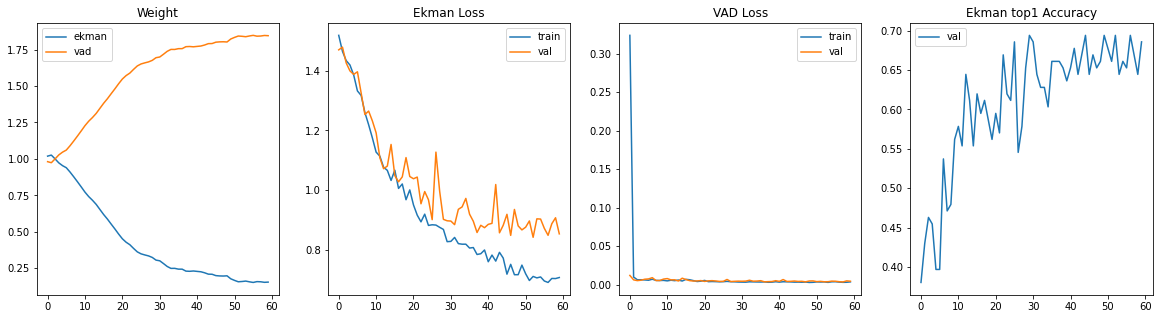

In [117]:
training_manager_sameOpt.plot_history()

### No Grad Norm, combined dataset (ablation on gradNorm)

In [ ]:
net_noGrad = MultiheadNetwork(bert)
net_noGrad.to(DEVICE)
training_manager_noGrad = TrainingManager(net_noGrad, dataloader, with_gradNorm=False)

In [ ]:
training_manager_noGrad.evaluate('combined')

In [ ]:
training_manager_noGrad.train(epochs=30, train_label='combined', val_label='combined')

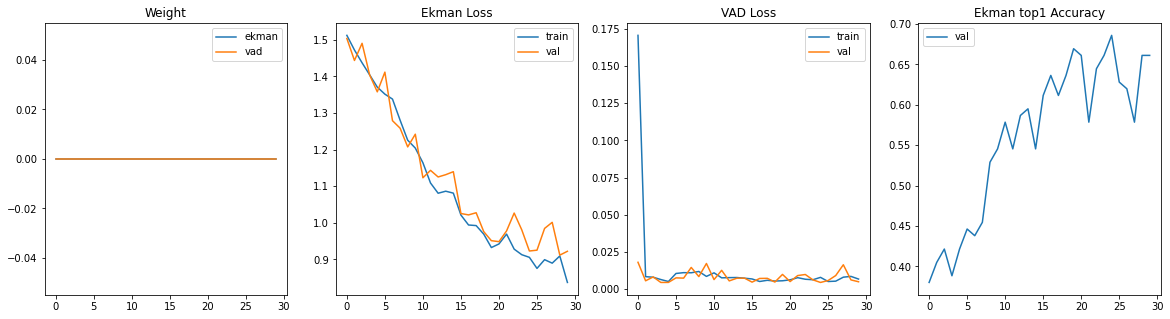

In [ ]:
# GradNorm combined
training_manager_noGrad.plot_history()

### No Grad Norm, Only Ekman dataset (baseline)

In [ ]:
net_ekman = MultiheadNetwork(bert)
net_ekman.to(DEVICE)
training_manager_ekman = TrainingManager(net_ekman, dataloader, with_gradNorm=False)

In [ ]:
training_manager_ekman.train(epochs=30, train_label='ekman', val_label='ekman')

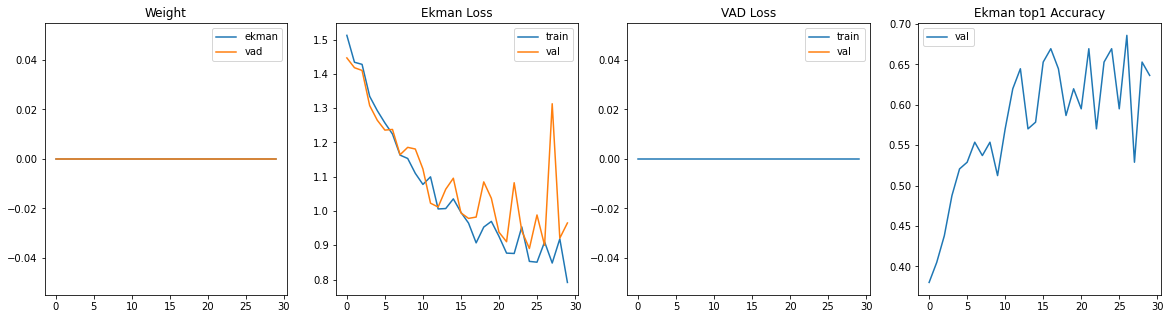

In [ ]:
training_manager_ekman.plot_history()

In [ ]:
# del net_ekman
# del training_manager_ekman

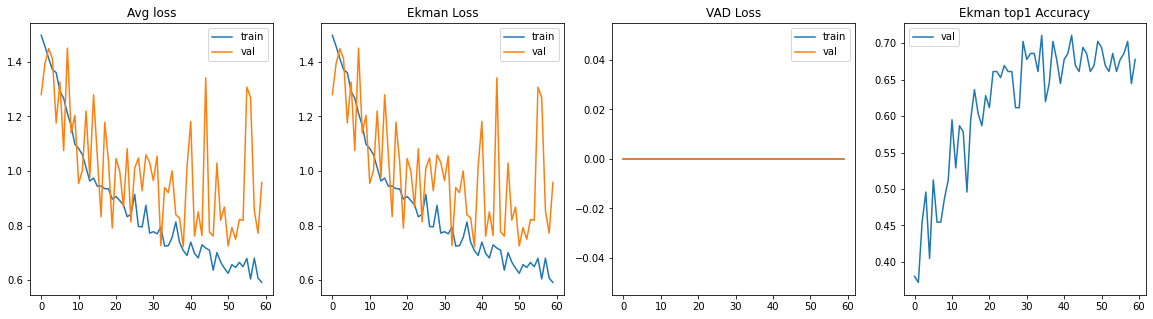

In [ ]:
# GradNorm
training_manager_multi.plot_history()


In [ ]:
#no GradNorm
training_manager_multi.train(epochs=50, train_label='ekman', val_label='ekman')

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1: train_avg_loss = 0.644
Epoch 1: ekman_loss = 0.644, vad_loss = 0.000
Epoch 1: val_avg_loss = 1.089
Epoch 1: ekman_loss = 1.089, vad_loss = 0.000
Epoch 1: val_ekman_accuracy = 0.603


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2: train_avg_loss = 0.593
Epoch 2: ekman_loss = 0.593, vad_loss = 0.000
Epoch 2: val_avg_loss = 1.055
Epoch 2: ekman_loss = 1.055, vad_loss = 0.000
Epoch 2: val_ekman_accuracy = 0.579


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3: train_avg_loss = 0.586
Epoch 3: ekman_loss = 0.586, vad_loss = 0.000
Epoch 3: val_avg_loss = 1.064
Epoch 3: ekman_loss = 1.064, vad_loss = 0.000
Epoch 3: val_ekman_accuracy = 0.620


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4: train_avg_loss = 0.631
Epoch 4: ekman_loss = 0.631, vad_loss = 0.000
Epoch 4: val_avg_loss = 1.339
Epoch 4: ekman_loss = 1.339, vad_loss = 0.000
Epoch 4: val_ekman_accuracy = 0.537


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5: train_avg_loss = 0.647
Epoch 5: ekman_loss = 0.647, vad_loss = 0.000
Epoch 5: val_avg_loss = 1.129
Epoch 5: ekman_loss = 1.129, vad_loss = 0.000
Epoch 5: val_ekman_accuracy = 0.570


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6: train_avg_loss = 0.606
Epoch 6: ekman_loss = 0.606, vad_loss = 0.000
Epoch 6: val_avg_loss = 1.197
Epoch 6: ekman_loss = 1.197, vad_loss = 0.000
Epoch 6: val_ekman_accuracy = 0.579


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7: train_avg_loss = 0.593
Epoch 7: ekman_loss = 0.593, vad_loss = 0.000
Epoch 7: val_avg_loss = 1.094
Epoch 7: ekman_loss = 1.094, vad_loss = 0.000
Epoch 7: val_ekman_accuracy = 0.595


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8: train_avg_loss = 0.594
Epoch 8: ekman_loss = 0.594, vad_loss = 0.000
Epoch 8: val_avg_loss = 1.117
Epoch 8: ekman_loss = 1.117, vad_loss = 0.000
Epoch 8: val_ekman_accuracy = 0.636


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9: train_avg_loss = 0.622
Epoch 9: ekman_loss = 0.622, vad_loss = 0.000
Epoch 9: val_avg_loss = 1.109
Epoch 9: ekman_loss = 1.109, vad_loss = 0.000
Epoch 9: val_ekman_accuracy = 0.603


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10: train_avg_loss = 0.543
Epoch 10: ekman_loss = 0.543, vad_loss = 0.000
Epoch 10: val_avg_loss = 1.031
Epoch 10: ekman_loss = 1.031, vad_loss = 0.000
Epoch 10: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11: train_avg_loss = 0.558
Epoch 11: ekman_loss = 0.558, vad_loss = 0.000
Epoch 11: val_avg_loss = 1.143
Epoch 11: ekman_loss = 1.143, vad_loss = 0.000
Epoch 11: val_ekman_accuracy = 0.545


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12: train_avg_loss = 0.571
Epoch 12: ekman_loss = 0.571, vad_loss = 0.000
Epoch 12: val_avg_loss = 1.013
Epoch 12: ekman_loss = 1.013, vad_loss = 0.000
Epoch 12: val_ekman_accuracy = 0.595


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13: train_avg_loss = 0.563
Epoch 13: ekman_loss = 0.563, vad_loss = 0.000
Epoch 13: val_avg_loss = 0.981
Epoch 13: ekman_loss = 0.981, vad_loss = 0.000
Epoch 13: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14: train_avg_loss = 0.535
Epoch 14: ekman_loss = 0.535, vad_loss = 0.000
Epoch 14: val_avg_loss = 1.109
Epoch 14: ekman_loss = 1.109, vad_loss = 0.000
Epoch 14: val_ekman_accuracy = 0.628


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15: train_avg_loss = 0.577
Epoch 15: ekman_loss = 0.577, vad_loss = 0.000
Epoch 15: val_avg_loss = 1.137
Epoch 15: ekman_loss = 1.137, vad_loss = 0.000
Epoch 15: val_ekman_accuracy = 0.595


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16: train_avg_loss = 0.545
Epoch 16: ekman_loss = 0.545, vad_loss = 0.000
Epoch 16: val_avg_loss = 1.200
Epoch 16: ekman_loss = 1.200, vad_loss = 0.000
Epoch 16: val_ekman_accuracy = 0.554


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17: train_avg_loss = 0.606
Epoch 17: ekman_loss = 0.606, vad_loss = 0.000
Epoch 17: val_avg_loss = 1.058
Epoch 17: ekman_loss = 1.058, vad_loss = 0.000
Epoch 17: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18: train_avg_loss = 0.554
Epoch 18: ekman_loss = 0.554, vad_loss = 0.000
Epoch 18: val_avg_loss = 1.050
Epoch 18: ekman_loss = 1.050, vad_loss = 0.000
Epoch 18: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19: train_avg_loss = 0.538
Epoch 19: ekman_loss = 0.538, vad_loss = 0.000
Epoch 19: val_avg_loss = 1.500
Epoch 19: ekman_loss = 1.500, vad_loss = 0.000
Epoch 19: val_ekman_accuracy = 0.587


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20: train_avg_loss = 0.574
Epoch 20: ekman_loss = 0.574, vad_loss = 0.000
Epoch 20: val_avg_loss = 1.302
Epoch 20: ekman_loss = 1.302, vad_loss = 0.000
Epoch 20: val_ekman_accuracy = 0.636


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21: train_avg_loss = 0.502
Epoch 21: ekman_loss = 0.502, vad_loss = 0.000
Epoch 21: val_avg_loss = 1.310
Epoch 21: ekman_loss = 1.310, vad_loss = 0.000
Epoch 21: val_ekman_accuracy = 0.595


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22: train_avg_loss = 0.562
Epoch 22: ekman_loss = 0.562, vad_loss = 0.000
Epoch 22: val_avg_loss = 1.606
Epoch 22: ekman_loss = 1.606, vad_loss = 0.000
Epoch 22: val_ekman_accuracy = 0.570


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23: train_avg_loss = 0.500
Epoch 23: ekman_loss = 0.500, vad_loss = 0.000
Epoch 23: val_avg_loss = 1.295
Epoch 23: ekman_loss = 1.295, vad_loss = 0.000
Epoch 23: val_ekman_accuracy = 0.562


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24: train_avg_loss = 0.529
Epoch 24: ekman_loss = 0.529, vad_loss = 0.000
Epoch 24: val_avg_loss = 1.079
Epoch 24: ekman_loss = 1.079, vad_loss = 0.000
Epoch 24: val_ekman_accuracy = 0.570


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25: train_avg_loss = 0.485
Epoch 25: ekman_loss = 0.485, vad_loss = 0.000
Epoch 25: val_avg_loss = 0.991
Epoch 25: ekman_loss = 0.991, vad_loss = 0.000
Epoch 25: val_ekman_accuracy = 0.653


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26: train_avg_loss = 0.526
Epoch 26: ekman_loss = 0.526, vad_loss = 0.000
Epoch 26: val_avg_loss = 1.294
Epoch 26: ekman_loss = 1.294, vad_loss = 0.000
Epoch 26: val_ekman_accuracy = 0.570


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27: train_avg_loss = 0.557
Epoch 27: ekman_loss = 0.557, vad_loss = 0.000
Epoch 27: val_avg_loss = 1.178
Epoch 27: ekman_loss = 1.178, vad_loss = 0.000
Epoch 27: val_ekman_accuracy = 0.620


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28: train_avg_loss = 0.476
Epoch 28: ekman_loss = 0.476, vad_loss = 0.000
Epoch 28: val_avg_loss = 1.630
Epoch 28: ekman_loss = 1.630, vad_loss = 0.000
Epoch 28: val_ekman_accuracy = 0.595


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29: train_avg_loss = 0.529
Epoch 29: ekman_loss = 0.529, vad_loss = 0.000
Epoch 29: val_avg_loss = 1.579
Epoch 29: ekman_loss = 1.579, vad_loss = 0.000
Epoch 29: val_ekman_accuracy = 0.595


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30: train_avg_loss = 0.507
Epoch 30: ekman_loss = 0.507, vad_loss = 0.000
Epoch 30: val_avg_loss = 1.314
Epoch 30: ekman_loss = 1.314, vad_loss = 0.000
Epoch 30: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 31: train_avg_loss = 0.481
Epoch 31: ekman_loss = 0.481, vad_loss = 0.000
Epoch 31: val_avg_loss = 1.267
Epoch 31: ekman_loss = 1.267, vad_loss = 0.000
Epoch 31: val_ekman_accuracy = 0.537


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 32: train_avg_loss = 0.544
Epoch 32: ekman_loss = 0.544, vad_loss = 0.000
Epoch 32: val_avg_loss = 1.162
Epoch 32: ekman_loss = 1.162, vad_loss = 0.000
Epoch 32: val_ekman_accuracy = 0.587


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 33: train_avg_loss = 0.495
Epoch 33: ekman_loss = 0.495, vad_loss = 0.000
Epoch 33: val_avg_loss = 1.293
Epoch 33: ekman_loss = 1.293, vad_loss = 0.000
Epoch 33: val_ekman_accuracy = 0.603


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 34: train_avg_loss = 0.499
Epoch 34: ekman_loss = 0.499, vad_loss = 0.000
Epoch 34: val_avg_loss = 1.780
Epoch 34: ekman_loss = 1.780, vad_loss = 0.000
Epoch 34: val_ekman_accuracy = 0.570


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 35: train_avg_loss = 0.494
Epoch 35: ekman_loss = 0.494, vad_loss = 0.000
Epoch 35: val_avg_loss = 1.169
Epoch 35: ekman_loss = 1.169, vad_loss = 0.000
Epoch 35: val_ekman_accuracy = 0.628


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 36: train_avg_loss = 0.453
Epoch 36: ekman_loss = 0.453, vad_loss = 0.000
Epoch 36: val_avg_loss = 1.181
Epoch 36: ekman_loss = 1.181, vad_loss = 0.000
Epoch 36: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 37: train_avg_loss = 0.543
Epoch 37: ekman_loss = 0.543, vad_loss = 0.000
Epoch 37: val_avg_loss = 1.089
Epoch 37: ekman_loss = 1.089, vad_loss = 0.000
Epoch 37: val_ekman_accuracy = 0.661


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 38: train_avg_loss = 0.506
Epoch 38: ekman_loss = 0.506, vad_loss = 0.000
Epoch 38: val_avg_loss = 1.362
Epoch 38: ekman_loss = 1.362, vad_loss = 0.000
Epoch 38: val_ekman_accuracy = 0.521


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 39: train_avg_loss = 0.447
Epoch 39: ekman_loss = 0.447, vad_loss = 0.000
Epoch 39: val_avg_loss = 1.198
Epoch 39: ekman_loss = 1.198, vad_loss = 0.000
Epoch 39: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40: train_avg_loss = 0.474
Epoch 40: ekman_loss = 0.474, vad_loss = 0.000
Epoch 40: val_avg_loss = 1.289
Epoch 40: ekman_loss = 1.289, vad_loss = 0.000
Epoch 40: val_ekman_accuracy = 0.595


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 41: train_avg_loss = 0.430
Epoch 41: ekman_loss = 0.430, vad_loss = 0.000
Epoch 41: val_avg_loss = 1.256
Epoch 41: ekman_loss = 1.256, vad_loss = 0.000
Epoch 41: val_ekman_accuracy = 0.620


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 42: train_avg_loss = 0.486
Epoch 42: ekman_loss = 0.486, vad_loss = 0.000
Epoch 42: val_avg_loss = 1.433
Epoch 42: ekman_loss = 1.433, vad_loss = 0.000
Epoch 42: val_ekman_accuracy = 0.628


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 43: train_avg_loss = 0.424
Epoch 43: ekman_loss = 0.424, vad_loss = 0.000
Epoch 43: val_avg_loss = 1.129
Epoch 43: ekman_loss = 1.129, vad_loss = 0.000
Epoch 43: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 44: train_avg_loss = 0.453
Epoch 44: ekman_loss = 0.453, vad_loss = 0.000
Epoch 44: val_avg_loss = 1.229
Epoch 44: ekman_loss = 1.229, vad_loss = 0.000
Epoch 44: val_ekman_accuracy = 0.587


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 45: train_avg_loss = 0.436
Epoch 45: ekman_loss = 0.436, vad_loss = 0.000
Epoch 45: val_avg_loss = 1.205
Epoch 45: ekman_loss = 1.205, vad_loss = 0.000
Epoch 45: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 46: train_avg_loss = 0.563
Epoch 46: ekman_loss = 0.563, vad_loss = 0.000
Epoch 46: val_avg_loss = 1.271
Epoch 46: ekman_loss = 1.271, vad_loss = 0.000
Epoch 46: val_ekman_accuracy = 0.603


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 47: train_avg_loss = 0.416
Epoch 47: ekman_loss = 0.416, vad_loss = 0.000
Epoch 47: val_avg_loss = 1.210
Epoch 47: ekman_loss = 1.210, vad_loss = 0.000
Epoch 47: val_ekman_accuracy = 0.612


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 48: train_avg_loss = 0.441
Epoch 48: ekman_loss = 0.441, vad_loss = 0.000
Epoch 48: val_avg_loss = 1.240
Epoch 48: ekman_loss = 1.240, vad_loss = 0.000
Epoch 48: val_ekman_accuracy = 0.554


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 49: train_avg_loss = 0.416
Epoch 49: ekman_loss = 0.416, vad_loss = 0.000
Epoch 49: val_avg_loss = 1.147
Epoch 49: ekman_loss = 1.147, vad_loss = 0.000
Epoch 49: val_ekman_accuracy = 0.620


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 50: train_avg_loss = 0.467
Epoch 50: ekman_loss = 0.467, vad_loss = 0.000
Epoch 50: val_avg_loss = 1.505
Epoch 50: ekman_loss = 1.505, vad_loss = 0.000
Epoch 50: val_ekman_accuracy = 0.620


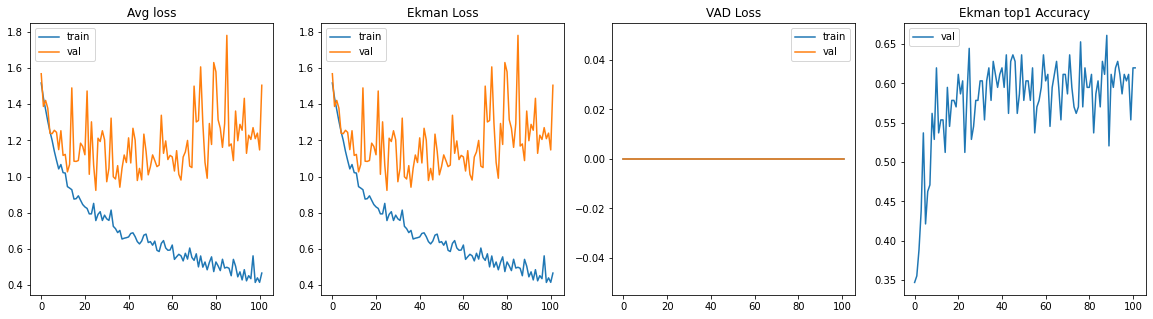

In [ ]:
training_manager_multi.plot_history()

In [ ]:
net2 = MultiheadNetwork(bert)
net2.to(DEVICE)
training_manager_multi_combined = TrainingManager(net2, dataloader)

In [ ]:
training_manager_multi_combined.evaluate(label='ekman')

  0%|          | 0/13 [00:00<?, ?it/s]

TEST SET (ekman)
Loss = 1.040
Accuracy = 69.42


In [ ]:
training_manager_multi_combined.train(epochs=10, train_label='combined', val_label='ekman')

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1: train_avg_loss = 1.486
Epoch 1: ekman_loss = 1.486, vad_loss = 0.001
Epoch 1: val_avg_loss = 1.143
Epoch 1: ekman_loss = 1.143, vad_loss = 0.000
Epoch 1: val_ekman_accuracy = 0.579


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2: train_avg_loss = 1.488
Epoch 2: ekman_loss = 1.488, vad_loss = 0.001
Epoch 2: val_avg_loss = 1.117
Epoch 2: ekman_loss = 1.117, vad_loss = 0.000
Epoch 2: val_ekman_accuracy = 0.595


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3: train_avg_loss = 1.496
Epoch 3: ekman_loss = 1.496, vad_loss = 0.001
Epoch 3: val_avg_loss = 1.053
Epoch 3: ekman_loss = 1.053, vad_loss = 0.000
Epoch 3: val_ekman_accuracy = 0.579


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4: train_avg_loss = 1.489
Epoch 4: ekman_loss = 1.489, vad_loss = 0.001
Epoch 4: val_avg_loss = 1.063
Epoch 4: ekman_loss = 1.063, vad_loss = 0.000
Epoch 4: val_ekman_accuracy = 0.645


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5: train_avg_loss = 1.484
Epoch 5: ekman_loss = 1.484, vad_loss = 0.001
Epoch 5: val_avg_loss = 1.261
Epoch 5: ekman_loss = 1.261, vad_loss = 0.000
Epoch 5: val_ekman_accuracy = 0.620


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6: train_avg_loss = 1.495
Epoch 6: ekman_loss = 1.495, vad_loss = 0.001
Epoch 6: val_avg_loss = 1.067
Epoch 6: ekman_loss = 1.067, vad_loss = 0.000
Epoch 6: val_ekman_accuracy = 0.612


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7: train_avg_loss = 1.488
Epoch 7: ekman_loss = 1.488, vad_loss = 0.001
Epoch 7: val_avg_loss = 1.217
Epoch 7: ekman_loss = 1.217, vad_loss = 0.000
Epoch 7: val_ekman_accuracy = 0.579


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8: train_avg_loss = 1.494
Epoch 8: ekman_loss = 1.494, vad_loss = 0.001
Epoch 8: val_avg_loss = 1.077
Epoch 8: ekman_loss = 1.077, vad_loss = 0.000
Epoch 8: val_ekman_accuracy = 0.570


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9: train_avg_loss = 1.486
Epoch 9: ekman_loss = 1.486, vad_loss = 0.001
Epoch 9: val_avg_loss = 1.007
Epoch 9: ekman_loss = 1.007, vad_loss = 0.000
Epoch 9: val_ekman_accuracy = 0.628


  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10: train_avg_loss = 1.494
Epoch 10: ekman_loss = 1.494, vad_loss = 0.001
Epoch 10: val_avg_loss = 1.079
Epoch 10: ekman_loss = 1.079, vad_loss = 0.000
Epoch 10: val_ekman_accuracy = 0.612


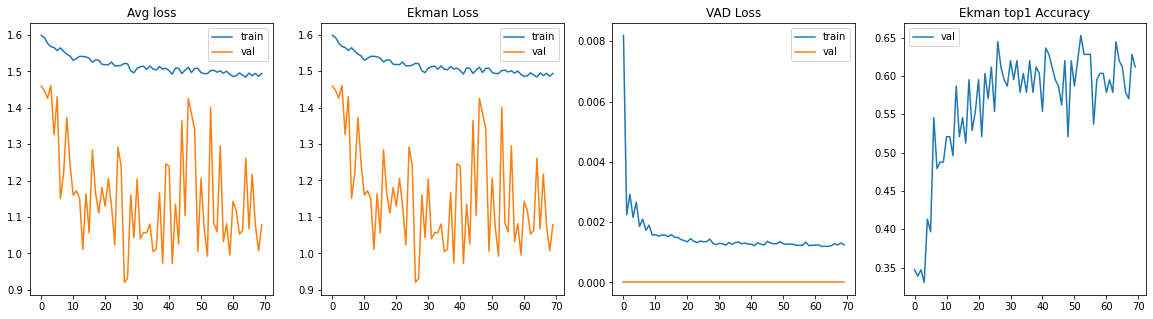

In [ ]:
training_manager_multi_combined.plot_history()

## Qualitative Evaluation

In [ ]:
results_df = pd.DataFrame([], columns = EKMAN_EMOTIONS + VAD_EMOTIONS)
NUM_EXAMPLES = 10
with torch.no_grad():
  sample = next(iter(dataloader['combined']['test']))
  X_id, X_mask, y, task = sample
  y_ekman = torch.nn.functional.one_hot(y[:, 0].to(int), num_classes = 5)
  y_display = torch.concatenate((y_ekman, y[:, 1:]), dim=-1)
  y_pred = net2(X_id, X_mask, task)
  
  for i in range(NUM_EXAMPLES):
    sent = tokenizer.decode(X_id[i], skip_special_tokens=True)
    row_gt = {heading: val for heading, val, in zip(results_df.columns,y_display[i].cpu().numpy())}
    row_pred = {heading: val for heading, val, in zip(results_df.columns, y_pred[i].cpu().numpy())}
    results_df = pd.concat((results_df, pd.DataFrame([row_gt, row_pred], index=[f'gt {i}', f'pred {i}'])))
    print(sent)
results_df

a short bus ride away is cheung sha beach, 3 km ( 2 miles ) long, and popular for its white sand and excellent facilities.
johnlopresti said... thought i would post a link with a cute title related to the post.
he was wearing a new jacket and snow boots, but he had on a hawaiian shirt underneath and khaki shorts of all things.
and our roots go deep.
sri lanka clashes kill 129 troops
i'm gonna take the plug out.
in return, we will recognize target as a sponsor during our event and in the event program.
experience the peace and beauty of coastal rhythms.
" the core of our strategy is to lead in technology and attack the high - performance segments of the market, " said john kelly, senior vice president in charge of ibm's technology group.
enclosures


,anger-disgust,fear,happy,sad,surprise,V,A,D
gt 0,1.000000,0.000000,0.000000,0.000000,0.000000,0.600444,0.554256,0.576426
pred 0,-1.609438,-1.609438,-1.609438,-1.609438,-1.609438,0.577078,0.554826,0.569422
gt 1,1.000000,0.000000,0.000000,0.000000,0.000000,0.667655,0.505799,0.546263
pred 1,-1.609438,-1.609438,-1.609438,-1.609438,-1.609438,0.576921,0.571002,0.580984
gt 2,1.000000,0.000000,0.000000,0.000000,0.000000,0.562718,0.562718,0.605555
pred 2,-1.609438,-1.609438,-1.609438,-1.609438,-1.609438,0.550031,0.586517,0.591497
gt 3,1.000000,0.000000,0.000000,0.000000,0.000000,0.564532,0.564532,0.602168
pred 3,-1.609438,-1.609438,-1.609438,-1.609438,-1.609438,0.606954,0.544989,0.574708
gt 4,1.000000,0.000000,0.000000,0.000000,0.000000,0.429548,0.751708,0.500423
pred 4,-1.609438,-1.609438,-1.609438,-1.609438,-1.609438,0.509981,0.664883,0.625027


In [ ]:
EKMAN_EMOTIONS

['anger-disgust', 'fear', 'happy', 'sad', 'surprise']